# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

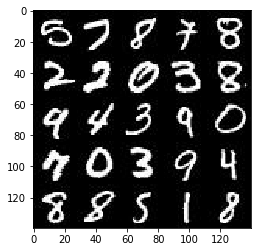

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

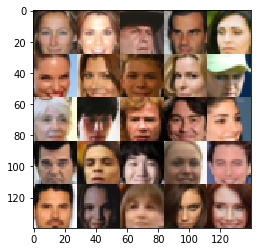

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data' )
    
    learning_rate = tf.placeholder( tf.float32, name='learning_rate')

    return input_real, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [77]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Alpha used in the leakyRelu
    #Implemened as per DCGAN paper
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #layer 1 input  = 32, 32, 3
        cov1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer_1 = tf.maximum(alpha*cov1, cov1)
        
        #layer 2 16, 16, 64  includes batch norm
        cov2 = tf.layers.conv2d(layer_1, 128, 5, strides=2, padding='same')
        cov2b = tf.layers.batch_normalization(cov2, training=True)
        cov2b = tf.layers.dropout(cov2b, 0.3)  
        layer_2 = tf.maximum(alpha*cov2b, cov2b)
        
        #layer 3 8, 8, 128 includes batch norm
        cov3 = tf.layers.conv2d(layer_2, 256, 5, strides=2, padding='same')
        cov3b = tf.layers.batch_normalization(cov3, training=True)
        layer_3 = tf.maximum(alpha*cov3b, cov3b)
        
        #layer 4 4,4,256
        flatten = tf.reshape(layer_3, (-1, 4*4*256 ))
        
        #output
        tensor_logits = tf.layers.dense(flatten, 1, activation=None)
        tensor_output = tf.sigmoid(tensor_logits)

    
    return tensor_output, tensor_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [78]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #DCGAN Paper
    
    start = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
    
        #Fully connected layer  7x7x256
        fc1 = tf.layers.dense(z,7*7*256, use_bias=False, activation=None)
        fc1 = tf.reshape(fc1, (-1, 7,7,256))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.layers.dropout(fc1, 0.3)      
        fc1 = tf.maximum (alpha * fc1, fc1)


        #change to 14x14x128
        cov2 = tf.layers.conv2d_transpose(fc1, 128, 5, strides=2, kernel_initializer=start, padding='same')
        cov2 = tf.layers.batch_normalization(cov2, training=is_train)
        cov2 = tf.maximum (alpha * cov2, cov2)


        #change to 28x128x64
        cov3 = tf.layers.conv2d_transpose(cov2, 64, 5, strides=2, kernel_initializer=start, padding='same')
        cov3 = tf.layers.batch_normalization(cov3, training=is_train)
        cov3 = tf.maximum (alpha * cov3, cov3)


        #output layer 28x28x3
        logits = tf.layers.conv2d_transpose(cov3, out_channel_dim, 3, strides=1, kernel_initializer=start, padding='same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [79]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
        #d_loss = d_loss_real + g_loss_fake
        
    gen_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    dmodel_real, dlogits_real = discriminator(input_real, reuse=False, alpha=alpha)
    dmodel_fake, dlogits_fake = discriminator(gen_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits= dlogits_real,
            labels=tf.ones_like(dmodel_real) * 0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dlogits_fake,
                                             labels=tf.zeros_like(dmodel_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dlogits_fake,
                                                labels=tf.ones_like(dmodel_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [80]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #print (d_vars)
    #print (g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [82]:
import time
print (time.time())
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
           
    input_real, z_data, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, z_data, data_shape[-1], alpha=0.2)
    
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                start_time = time.time()
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train, feed_dict={input_real: batch_images, z_data: batch_z, learn_rate:learning_rate} )
                _ = sess.run(g_train, feed_dict={input_real: batch_images, z_data: batch_z, learn_rate:learning_rate})

                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_data: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({z_data:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g),
                      "... Time spent={:.4f}".format(time.time() - start_time))    

                if steps % 200 == 0:
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
                
                
                
                

1514932703.6476011


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10... Discriminator Loss: 0.9139... Generator Loss: 5.3422 ... Time spent=0.2321
Epoch 1/2 Step 20... Discriminator Loss: 2.3752... Generator Loss: 0.2248 ... Time spent=0.1554
Epoch 1/2 Step 30... Discriminator Loss: 2.1782... Generator Loss: 0.1963 ... Time spent=0.1544
Epoch 1/2 Step 40... Discriminator Loss: 2.0483... Generator Loss: 0.2330 ... Time spent=0.1549
Epoch 1/2 Step 50... Discriminator Loss: 1.8754... Generator Loss: 0.2858 ... Time spent=0.1580
Epoch 1/2 Step 60... Discriminator Loss: 1.9205... Generator Loss: 0.2701 ... Time spent=0.1550
Epoch 1/2 Step 70... Discriminator Loss: 1.6791... Generator Loss: 0.3585 ... Time spent=0.1564
Epoch 1/2 Step 80... Discriminator Loss: 1.6828... Generator Loss: 0.3664 ... Time spent=0.1553
Epoch 1/2 Step 90... Discriminator Loss: 1.6598... Generator Loss: 0.3608 ... Time spent=0.1570
Epoch 1/2 Step 100... Discriminator Loss: 1.6395... Generator Loss: 0.3760 ... Time spent=0.1547
Epoch 1/2 Step 110... Discriminator Los

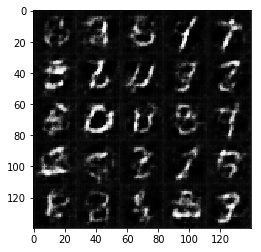

Epoch 1/2 Step 210... Discriminator Loss: 1.4674... Generator Loss: 1.4254 ... Time spent=0.1575
Epoch 1/2 Step 220... Discriminator Loss: 1.3548... Generator Loss: 1.0525 ... Time spent=0.1562
Epoch 1/2 Step 230... Discriminator Loss: 1.4065... Generator Loss: 1.0849 ... Time spent=0.1551
Epoch 1/2 Step 240... Discriminator Loss: 1.3702... Generator Loss: 1.2518 ... Time spent=0.1555
Epoch 1/2 Step 250... Discriminator Loss: 1.4148... Generator Loss: 1.1293 ... Time spent=0.1550
Epoch 1/2 Step 260... Discriminator Loss: 1.4335... Generator Loss: 1.0310 ... Time spent=0.1556
Epoch 1/2 Step 270... Discriminator Loss: 1.3412... Generator Loss: 1.0288 ... Time spent=0.1570
Epoch 1/2 Step 280... Discriminator Loss: 1.5108... Generator Loss: 1.4848 ... Time spent=0.1558
Epoch 1/2 Step 290... Discriminator Loss: 1.4727... Generator Loss: 1.1290 ... Time spent=0.1552
Epoch 1/2 Step 300... Discriminator Loss: 1.4317... Generator Loss: 1.3219 ... Time spent=0.1549
Epoch 1/2 Step 310... Discrimi

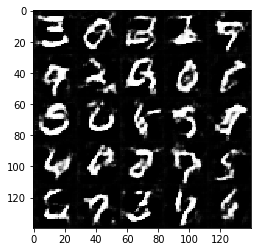

Epoch 1/2 Step 410... Discriminator Loss: 1.2893... Generator Loss: 0.8313 ... Time spent=0.1571
Epoch 1/2 Step 420... Discriminator Loss: 1.4556... Generator Loss: 1.2243 ... Time spent=0.1572
Epoch 1/2 Step 430... Discriminator Loss: 1.3124... Generator Loss: 1.3947 ... Time spent=0.1580
Epoch 1/2 Step 440... Discriminator Loss: 1.1896... Generator Loss: 0.8115 ... Time spent=0.1582
Epoch 1/2 Step 450... Discriminator Loss: 1.6561... Generator Loss: 1.4995 ... Time spent=0.1570
Epoch 1/2 Step 460... Discriminator Loss: 1.1271... Generator Loss: 1.0111 ... Time spent=0.1561
Epoch 1/2 Step 470... Discriminator Loss: 1.6608... Generator Loss: 1.7018 ... Time spent=0.1560
Epoch 1/2 Step 480... Discriminator Loss: 1.2617... Generator Loss: 1.2186 ... Time spent=0.1558
Epoch 1/2 Step 490... Discriminator Loss: 1.3020... Generator Loss: 1.0478 ... Time spent=0.1572
Epoch 1/2 Step 500... Discriminator Loss: 1.2694... Generator Loss: 0.7314 ... Time spent=0.1574
Epoch 1/2 Step 510... Discrimi

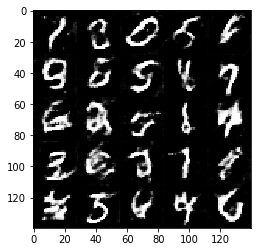

Epoch 1/2 Step 610... Discriminator Loss: 1.6802... Generator Loss: 0.3924 ... Time spent=0.1587
Epoch 1/2 Step 620... Discriminator Loss: 1.4736... Generator Loss: 0.4663 ... Time spent=0.1587
Epoch 1/2 Step 630... Discriminator Loss: 1.9558... Generator Loss: 0.2422 ... Time spent=0.1596
Epoch 1/2 Step 640... Discriminator Loss: 0.9842... Generator Loss: 1.2567 ... Time spent=0.1560
Epoch 1/2 Step 650... Discriminator Loss: 1.3681... Generator Loss: 1.0049 ... Time spent=0.1564
Epoch 1/2 Step 660... Discriminator Loss: 1.2008... Generator Loss: 1.1394 ... Time spent=0.1562
Epoch 1/2 Step 670... Discriminator Loss: 1.4324... Generator Loss: 0.4691 ... Time spent=0.1557
Epoch 1/2 Step 680... Discriminator Loss: 1.9215... Generator Loss: 0.2741 ... Time spent=0.1551
Epoch 1/2 Step 690... Discriminator Loss: 1.3224... Generator Loss: 0.5832 ... Time spent=0.1558
Epoch 1/2 Step 700... Discriminator Loss: 1.4963... Generator Loss: 0.4267 ... Time spent=0.1581
Epoch 1/2 Step 710... Discrimi

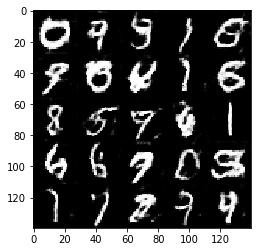

Epoch 1/2 Step 810... Discriminator Loss: 1.5877... Generator Loss: 0.3806 ... Time spent=0.1568
Epoch 1/2 Step 820... Discriminator Loss: 1.1799... Generator Loss: 1.1880 ... Time spent=0.1616
Epoch 1/2 Step 830... Discriminator Loss: 1.5261... Generator Loss: 0.4398 ... Time spent=0.1586
Epoch 1/2 Step 840... Discriminator Loss: 1.3214... Generator Loss: 0.5789 ... Time spent=0.1593
Epoch 1/2 Step 850... Discriminator Loss: 1.6545... Generator Loss: 0.3989 ... Time spent=0.1585
Epoch 1/2 Step 860... Discriminator Loss: 1.3490... Generator Loss: 0.5626 ... Time spent=0.1586
Epoch 1/2 Step 870... Discriminator Loss: 1.3039... Generator Loss: 0.5876 ... Time spent=0.2019
Epoch 1/2 Step 880... Discriminator Loss: 1.5229... Generator Loss: 0.4593 ... Time spent=0.1567
Epoch 1/2 Step 890... Discriminator Loss: 1.1188... Generator Loss: 0.7944 ... Time spent=0.2405
Epoch 1/2 Step 900... Discriminator Loss: 1.5398... Generator Loss: 0.4537 ... Time spent=0.2426
Epoch 1/2 Step 910... Discrimi

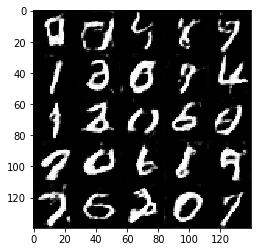

Epoch 2/2 Step 1010... Discriminator Loss: 1.1054... Generator Loss: 0.7727 ... Time spent=0.1579
Epoch 2/2 Step 1020... Discriminator Loss: 1.8802... Generator Loss: 0.2947 ... Time spent=0.1568
Epoch 2/2 Step 1030... Discriminator Loss: 1.6734... Generator Loss: 0.3571 ... Time spent=0.1597
Epoch 2/2 Step 1040... Discriminator Loss: 1.0808... Generator Loss: 1.3269 ... Time spent=0.1590
Epoch 2/2 Step 1050... Discriminator Loss: 1.1348... Generator Loss: 1.6492 ... Time spent=0.1594
Epoch 2/2 Step 1060... Discriminator Loss: 1.1398... Generator Loss: 1.2723 ... Time spent=0.1583
Epoch 2/2 Step 1070... Discriminator Loss: 1.1656... Generator Loss: 1.8012 ... Time spent=0.1591
Epoch 2/2 Step 1080... Discriminator Loss: 1.1219... Generator Loss: 1.1340 ... Time spent=0.1585
Epoch 2/2 Step 1090... Discriminator Loss: 2.4988... Generator Loss: 0.1744 ... Time spent=0.1582
Epoch 2/2 Step 1100... Discriminator Loss: 1.3696... Generator Loss: 0.5219 ... Time spent=0.1605
Epoch 2/2 Step 1110.

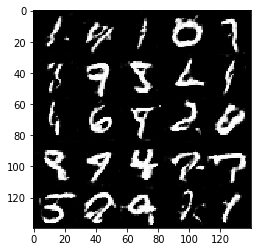

Epoch 2/2 Step 1210... Discriminator Loss: 1.4096... Generator Loss: 0.5176 ... Time spent=0.1588
Epoch 2/2 Step 1220... Discriminator Loss: 1.2052... Generator Loss: 1.8239 ... Time spent=0.1595
Epoch 2/2 Step 1230... Discriminator Loss: 1.6393... Generator Loss: 0.4343 ... Time spent=0.1602
Epoch 2/2 Step 1240... Discriminator Loss: 1.3003... Generator Loss: 0.5992 ... Time spent=0.1586
Epoch 2/2 Step 1250... Discriminator Loss: 0.9729... Generator Loss: 1.0627 ... Time spent=0.1591
Epoch 2/2 Step 1260... Discriminator Loss: 2.1299... Generator Loss: 0.2961 ... Time spent=0.1593
Epoch 2/2 Step 1270... Discriminator Loss: 0.9852... Generator Loss: 1.0247 ... Time spent=0.1586
Epoch 2/2 Step 1280... Discriminator Loss: 1.0722... Generator Loss: 1.5572 ... Time spent=0.1596
Epoch 2/2 Step 1290... Discriminator Loss: 1.1123... Generator Loss: 1.5274 ... Time spent=0.1578
Epoch 2/2 Step 1300... Discriminator Loss: 0.8780... Generator Loss: 1.3166 ... Time spent=0.1581
Epoch 2/2 Step 1310.

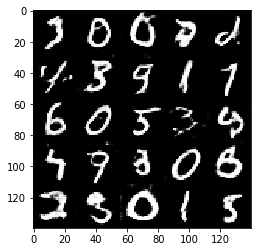

Epoch 2/2 Step 1410... Discriminator Loss: 1.8219... Generator Loss: 0.3254 ... Time spent=0.1595
Epoch 2/2 Step 1420... Discriminator Loss: 1.3267... Generator Loss: 0.5983 ... Time spent=0.1596
Epoch 2/2 Step 1430... Discriminator Loss: 0.8801... Generator Loss: 1.4182 ... Time spent=0.1601
Epoch 2/2 Step 1440... Discriminator Loss: 1.3612... Generator Loss: 0.6233 ... Time spent=0.1594
Epoch 2/2 Step 1450... Discriminator Loss: 1.3688... Generator Loss: 0.5301 ... Time spent=0.1604
Epoch 2/2 Step 1460... Discriminator Loss: 1.6373... Generator Loss: 0.3808 ... Time spent=0.1600
Epoch 2/2 Step 1470... Discriminator Loss: 1.0269... Generator Loss: 0.9239 ... Time spent=0.1597
Epoch 2/2 Step 1480... Discriminator Loss: 1.4599... Generator Loss: 0.4810 ... Time spent=0.1595
Epoch 2/2 Step 1490... Discriminator Loss: 1.1587... Generator Loss: 0.7402 ... Time spent=0.1569
Epoch 2/2 Step 1500... Discriminator Loss: 1.0213... Generator Loss: 0.8810 ... Time spent=0.1576
Epoch 2/2 Step 1510.

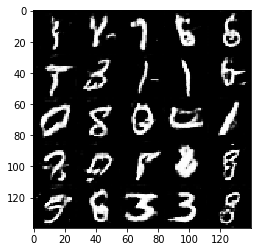

Epoch 2/2 Step 1610... Discriminator Loss: 1.0873... Generator Loss: 0.7713 ... Time spent=0.1612
Epoch 2/2 Step 1620... Discriminator Loss: 1.1534... Generator Loss: 1.5150 ... Time spent=0.1591
Epoch 2/2 Step 1630... Discriminator Loss: 1.7666... Generator Loss: 0.3747 ... Time spent=0.1596
Epoch 2/2 Step 1640... Discriminator Loss: 1.3418... Generator Loss: 0.5517 ... Time spent=0.1590
Epoch 2/2 Step 1650... Discriminator Loss: 1.0994... Generator Loss: 0.7842 ... Time spent=0.1594
Epoch 2/2 Step 1660... Discriminator Loss: 0.9154... Generator Loss: 1.5069 ... Time spent=0.1584
Epoch 2/2 Step 1670... Discriminator Loss: 1.5094... Generator Loss: 0.5206 ... Time spent=0.1614
Epoch 2/2 Step 1680... Discriminator Loss: 1.7123... Generator Loss: 0.3938 ... Time spent=0.1575
Epoch 2/2 Step 1690... Discriminator Loss: 1.0788... Generator Loss: 0.8031 ... Time spent=0.1581
Epoch 2/2 Step 1700... Discriminator Loss: 0.9051... Generator Loss: 1.1886 ... Time spent=0.1578
Epoch 2/2 Step 1710.

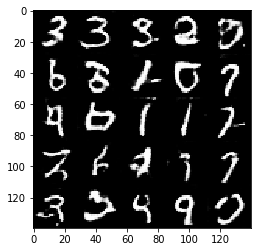

Epoch 2/2 Step 1810... Discriminator Loss: 1.2261... Generator Loss: 0.6641 ... Time spent=0.1610
Epoch 2/2 Step 1820... Discriminator Loss: 1.5798... Generator Loss: 0.4656 ... Time spent=0.1581
Epoch 2/2 Step 1830... Discriminator Loss: 0.8842... Generator Loss: 1.5084 ... Time spent=0.1589
Epoch 2/2 Step 1840... Discriminator Loss: 1.5367... Generator Loss: 0.5057 ... Time spent=0.1576
Epoch 2/2 Step 1850... Discriminator Loss: 1.9183... Generator Loss: 0.2798 ... Time spent=0.1570
Epoch 2/2 Step 1860... Discriminator Loss: 1.2654... Generator Loss: 0.6124 ... Time spent=0.1571
Epoch 2/2 Step 1870... Discriminator Loss: 1.1175... Generator Loss: 0.7436 ... Time spent=0.1569


In [51]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 Step 10... Discriminator Loss: 3.3050... Generator Loss: 0.3745 ... Time spent=0.1464
Epoch 1/2 Step 20... Discriminator Loss: 1.0955... Generator Loss: 1.4718 ... Time spent=0.0643
Epoch 1/2 Step 30... Discriminator Loss: 4.1384... Generator Loss: 0.0500 ... Time spent=0.0639
Epoch 1/2 Step 40... Discriminator Loss: 2.0847... Generator Loss: 0.5640 ... Time spent=0.0651
Epoch 1/2 Step 50... Discriminator Loss: 2.9647... Generator Loss: 0.1076 ... Time spent=0.0633
Epoch 1/2 Step 60... Discriminator Loss: 1.2054... Generator Loss: 1.0218 ... Time spent=0.0636
Epoch 1/2 Step 70... Discriminator Loss: 1.8813... Generator Loss: 2.0406 ... Time spent=0.0668
Epoch 1/2 Step 80... Discriminator Loss: 1.4789... Generator Loss: 0.5858 ... Time spent=0.0640
Epoch 1/2 Step 90... Discriminator Loss: 1.5912... Generator Loss: 1.7871 ... Time spent=0.0662
Epoch 1/2 Step 100... Discriminator Loss: 1.6853... Generator Loss: 0.3752 ... Time spent=0.0638
Epoch 1/2 Step 110... Discriminator Los

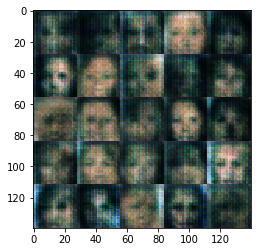

Epoch 1/2 Step 210... Discriminator Loss: 1.6629... Generator Loss: 0.4777 ... Time spent=0.0639
Epoch 1/2 Step 220... Discriminator Loss: 1.5871... Generator Loss: 0.5973 ... Time spent=0.0633
Epoch 1/2 Step 230... Discriminator Loss: 1.6326... Generator Loss: 0.6228 ... Time spent=0.0633
Epoch 1/2 Step 240... Discriminator Loss: 1.2428... Generator Loss: 0.7837 ... Time spent=0.0634
Epoch 1/2 Step 250... Discriminator Loss: 1.3708... Generator Loss: 0.6543 ... Time spent=0.0656
Epoch 1/2 Step 260... Discriminator Loss: 1.5934... Generator Loss: 0.6735 ... Time spent=0.0630
Epoch 1/2 Step 270... Discriminator Loss: 1.6906... Generator Loss: 0.4582 ... Time spent=0.0638
Epoch 1/2 Step 280... Discriminator Loss: 1.2805... Generator Loss: 0.7748 ... Time spent=0.0639
Epoch 1/2 Step 290... Discriminator Loss: 1.2762... Generator Loss: 0.8112 ... Time spent=0.0648
Epoch 1/2 Step 300... Discriminator Loss: 1.2890... Generator Loss: 0.7962 ... Time spent=0.0638
Epoch 1/2 Step 310... Discrimi

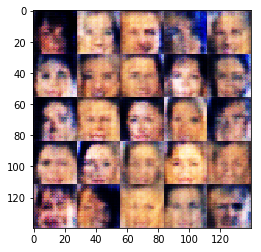

Epoch 1/2 Step 410... Discriminator Loss: 1.4947... Generator Loss: 0.6200 ... Time spent=0.0642
Epoch 1/2 Step 420... Discriminator Loss: 1.3343... Generator Loss: 0.8023 ... Time spent=0.0627
Epoch 1/2 Step 430... Discriminator Loss: 1.5412... Generator Loss: 0.6711 ... Time spent=0.0631
Epoch 1/2 Step 440... Discriminator Loss: 1.6339... Generator Loss: 0.7378 ... Time spent=0.0633
Epoch 1/2 Step 450... Discriminator Loss: 1.9482... Generator Loss: 0.5180 ... Time spent=0.0635
Epoch 1/2 Step 460... Discriminator Loss: 1.3572... Generator Loss: 0.6969 ... Time spent=0.0637
Epoch 1/2 Step 470... Discriminator Loss: 1.4795... Generator Loss: 0.7157 ... Time spent=0.0635
Epoch 1/2 Step 480... Discriminator Loss: 1.3953... Generator Loss: 0.5642 ... Time spent=0.0655
Epoch 1/2 Step 490... Discriminator Loss: 1.5276... Generator Loss: 0.7457 ... Time spent=0.0646
Epoch 1/2 Step 500... Discriminator Loss: 1.9626... Generator Loss: 0.3207 ... Time spent=0.0631
Epoch 1/2 Step 510... Discrimi

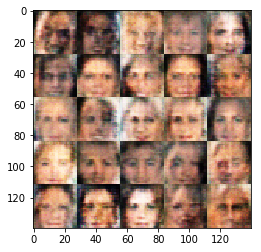

Epoch 1/2 Step 610... Discriminator Loss: 1.6454... Generator Loss: 0.5670 ... Time spent=0.0640
Epoch 1/2 Step 620... Discriminator Loss: 1.3502... Generator Loss: 0.6899 ... Time spent=0.0643
Epoch 1/2 Step 630... Discriminator Loss: 1.5279... Generator Loss: 0.6566 ... Time spent=0.0632
Epoch 1/2 Step 640... Discriminator Loss: 1.3887... Generator Loss: 0.7877 ... Time spent=0.0648
Epoch 1/2 Step 650... Discriminator Loss: 1.3572... Generator Loss: 0.7110 ... Time spent=0.0636
Epoch 1/2 Step 660... Discriminator Loss: 1.3723... Generator Loss: 0.6994 ... Time spent=0.0637
Epoch 1/2 Step 670... Discriminator Loss: 1.4406... Generator Loss: 0.6283 ... Time spent=0.0632
Epoch 1/2 Step 680... Discriminator Loss: 1.4336... Generator Loss: 0.7375 ... Time spent=0.0637
Epoch 1/2 Step 690... Discriminator Loss: 1.5667... Generator Loss: 0.6007 ... Time spent=0.0638
Epoch 1/2 Step 700... Discriminator Loss: 1.4356... Generator Loss: 0.6809 ... Time spent=0.0628
Epoch 1/2 Step 710... Discrimi

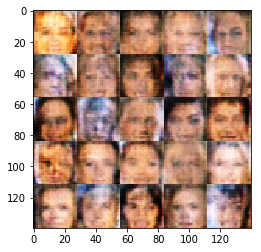

Epoch 1/2 Step 810... Discriminator Loss: 1.5812... Generator Loss: 0.7843 ... Time spent=0.0636
Epoch 1/2 Step 820... Discriminator Loss: 1.3055... Generator Loss: 0.8161 ... Time spent=0.0631
Epoch 1/2 Step 830... Discriminator Loss: 1.4159... Generator Loss: 0.7657 ... Time spent=0.0638
Epoch 1/2 Step 840... Discriminator Loss: 1.3303... Generator Loss: 0.7046 ... Time spent=0.0640
Epoch 1/2 Step 850... Discriminator Loss: 1.4270... Generator Loss: 0.7937 ... Time spent=0.0643
Epoch 1/2 Step 860... Discriminator Loss: 1.1741... Generator Loss: 0.8801 ... Time spent=0.0637
Epoch 1/2 Step 870... Discriminator Loss: 1.3245... Generator Loss: 0.7372 ... Time spent=0.0637
Epoch 1/2 Step 880... Discriminator Loss: 1.4449... Generator Loss: 0.7854 ... Time spent=0.0631
Epoch 1/2 Step 890... Discriminator Loss: 1.3787... Generator Loss: 0.7313 ... Time spent=0.0631
Epoch 1/2 Step 900... Discriminator Loss: 1.3391... Generator Loss: 0.7364 ... Time spent=0.0633
Epoch 1/2 Step 910... Discrimi

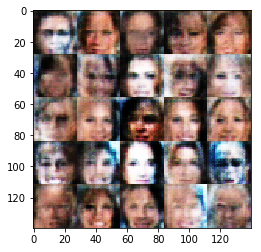

Epoch 1/2 Step 1010... Discriminator Loss: 1.4597... Generator Loss: 0.7205 ... Time spent=0.0639
Epoch 1/2 Step 1020... Discriminator Loss: 1.4550... Generator Loss: 0.7327 ... Time spent=0.0645
Epoch 1/2 Step 1030... Discriminator Loss: 1.3968... Generator Loss: 0.6614 ... Time spent=0.0645
Epoch 1/2 Step 1040... Discriminator Loss: 1.2978... Generator Loss: 0.7744 ... Time spent=0.0641
Epoch 1/2 Step 1050... Discriminator Loss: 1.3069... Generator Loss: 0.7141 ... Time spent=0.0644
Epoch 1/2 Step 1060... Discriminator Loss: 1.4995... Generator Loss: 0.5460 ... Time spent=0.0632
Epoch 1/2 Step 1070... Discriminator Loss: 1.4058... Generator Loss: 0.8205 ... Time spent=0.0628
Epoch 1/2 Step 1080... Discriminator Loss: 1.5315... Generator Loss: 0.6763 ... Time spent=0.0640
Epoch 1/2 Step 1090... Discriminator Loss: 1.3962... Generator Loss: 0.7193 ... Time spent=0.0644
Epoch 1/2 Step 1100... Discriminator Loss: 1.3928... Generator Loss: 0.7485 ... Time spent=0.0636
Epoch 1/2 Step 1110.

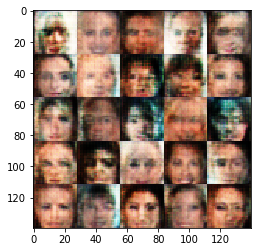

Epoch 1/2 Step 1210... Discriminator Loss: 1.3830... Generator Loss: 0.7806 ... Time spent=0.0657
Epoch 1/2 Step 1220... Discriminator Loss: 1.3110... Generator Loss: 0.6410 ... Time spent=0.0645
Epoch 1/2 Step 1230... Discriminator Loss: 1.4670... Generator Loss: 0.6781 ... Time spent=0.0637
Epoch 1/2 Step 1240... Discriminator Loss: 1.4770... Generator Loss: 0.8310 ... Time spent=0.0645
Epoch 1/2 Step 1250... Discriminator Loss: 1.3332... Generator Loss: 0.7794 ... Time spent=0.0643
Epoch 1/2 Step 1260... Discriminator Loss: 1.3307... Generator Loss: 0.7630 ... Time spent=0.0630
Epoch 1/2 Step 1270... Discriminator Loss: 1.2723... Generator Loss: 0.9193 ... Time spent=0.0635
Epoch 1/2 Step 1280... Discriminator Loss: 1.2278... Generator Loss: 0.7713 ... Time spent=0.0635
Epoch 1/2 Step 1290... Discriminator Loss: 1.2827... Generator Loss: 1.0835 ... Time spent=0.0635
Epoch 1/2 Step 1300... Discriminator Loss: 1.3664... Generator Loss: 0.7513 ... Time spent=0.0634
Epoch 1/2 Step 1310.

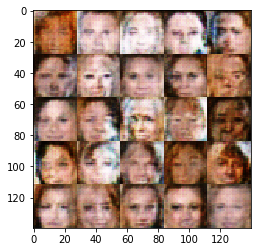

Epoch 1/2 Step 1410... Discriminator Loss: 1.4490... Generator Loss: 0.9714 ... Time spent=0.0633
Epoch 1/2 Step 1420... Discriminator Loss: 1.3055... Generator Loss: 0.7417 ... Time spent=0.0637
Epoch 1/2 Step 1430... Discriminator Loss: 1.4869... Generator Loss: 0.7661 ... Time spent=0.0633
Epoch 1/2 Step 1440... Discriminator Loss: 1.4852... Generator Loss: 0.6799 ... Time spent=0.0631
Epoch 1/2 Step 1450... Discriminator Loss: 1.4670... Generator Loss: 0.9101 ... Time spent=0.0645
Epoch 1/2 Step 1460... Discriminator Loss: 1.2685... Generator Loss: 0.7717 ... Time spent=0.0629
Epoch 1/2 Step 1470... Discriminator Loss: 1.2737... Generator Loss: 0.7800 ... Time spent=0.0634
Epoch 1/2 Step 1480... Discriminator Loss: 1.3760... Generator Loss: 0.7629 ... Time spent=0.0637
Epoch 1/2 Step 1490... Discriminator Loss: 1.4660... Generator Loss: 0.6413 ... Time spent=0.0642
Epoch 1/2 Step 1500... Discriminator Loss: 1.3140... Generator Loss: 0.6965 ... Time spent=0.0626
Epoch 1/2 Step 1510.

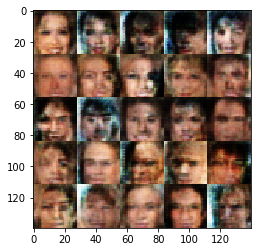

Epoch 1/2 Step 1610... Discriminator Loss: 1.3884... Generator Loss: 0.8619 ... Time spent=0.0634
Epoch 1/2 Step 1620... Discriminator Loss: 1.4848... Generator Loss: 0.8348 ... Time spent=0.0644
Epoch 1/2 Step 1630... Discriminator Loss: 1.4398... Generator Loss: 0.7445 ... Time spent=0.0645
Epoch 1/2 Step 1640... Discriminator Loss: 1.3534... Generator Loss: 0.7935 ... Time spent=0.0637
Epoch 1/2 Step 1650... Discriminator Loss: 1.3216... Generator Loss: 0.9256 ... Time spent=0.0650
Epoch 1/2 Step 1660... Discriminator Loss: 1.3659... Generator Loss: 0.8030 ... Time spent=0.0630
Epoch 1/2 Step 1670... Discriminator Loss: 1.2875... Generator Loss: 0.9574 ... Time spent=0.0638
Epoch 1/2 Step 1680... Discriminator Loss: 1.3481... Generator Loss: 0.8082 ... Time spent=0.0639
Epoch 1/2 Step 1690... Discriminator Loss: 1.3556... Generator Loss: 0.7931 ... Time spent=0.0634
Epoch 1/2 Step 1700... Discriminator Loss: 1.4999... Generator Loss: 0.6846 ... Time spent=0.0635
Epoch 1/2 Step 1710.

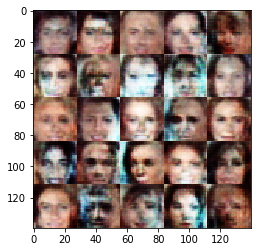

Epoch 1/2 Step 1810... Discriminator Loss: 1.4649... Generator Loss: 0.7303 ... Time spent=0.0640
Epoch 1/2 Step 1820... Discriminator Loss: 1.4439... Generator Loss: 0.8726 ... Time spent=0.0633
Epoch 1/2 Step 1830... Discriminator Loss: 1.5273... Generator Loss: 0.6507 ... Time spent=0.0635
Epoch 1/2 Step 1840... Discriminator Loss: 1.3789... Generator Loss: 0.7247 ... Time spent=0.0662
Epoch 1/2 Step 1850... Discriminator Loss: 1.4026... Generator Loss: 0.7167 ... Time spent=0.0640
Epoch 1/2 Step 1860... Discriminator Loss: 1.2637... Generator Loss: 0.9048 ... Time spent=0.0656
Epoch 1/2 Step 1870... Discriminator Loss: 1.3939... Generator Loss: 0.7163 ... Time spent=0.0639
Epoch 1/2 Step 1880... Discriminator Loss: 1.5544... Generator Loss: 0.7804 ... Time spent=0.0646
Epoch 1/2 Step 1890... Discriminator Loss: 1.3985... Generator Loss: 0.6073 ... Time spent=0.0644
Epoch 1/2 Step 1900... Discriminator Loss: 1.4280... Generator Loss: 0.7739 ... Time spent=0.0640
Epoch 1/2 Step 1910.

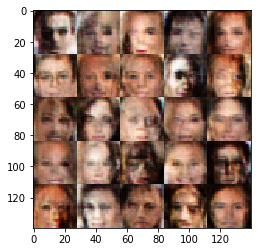

Epoch 1/2 Step 2010... Discriminator Loss: 1.2680... Generator Loss: 0.9772 ... Time spent=0.0643
Epoch 1/2 Step 2020... Discriminator Loss: 1.2858... Generator Loss: 0.7876 ... Time spent=0.0632
Epoch 1/2 Step 2030... Discriminator Loss: 1.4535... Generator Loss: 0.6678 ... Time spent=0.0635
Epoch 1/2 Step 2040... Discriminator Loss: 1.3044... Generator Loss: 0.8499 ... Time spent=0.0636
Epoch 1/2 Step 2050... Discriminator Loss: 1.4314... Generator Loss: 0.8518 ... Time spent=0.0633
Epoch 1/2 Step 2060... Discriminator Loss: 1.3256... Generator Loss: 0.8276 ... Time spent=0.0642
Epoch 1/2 Step 2070... Discriminator Loss: 1.3498... Generator Loss: 0.7561 ... Time spent=0.0636
Epoch 1/2 Step 2080... Discriminator Loss: 1.4183... Generator Loss: 0.7843 ... Time spent=0.0633
Epoch 1/2 Step 2090... Discriminator Loss: 1.4932... Generator Loss: 0.7800 ... Time spent=0.0650
Epoch 1/2 Step 2100... Discriminator Loss: 1.4633... Generator Loss: 0.8447 ... Time spent=0.0631
Epoch 1/2 Step 2110.

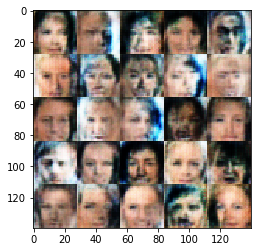

Epoch 1/2 Step 2210... Discriminator Loss: 1.3259... Generator Loss: 0.7638 ... Time spent=0.0641
Epoch 1/2 Step 2220... Discriminator Loss: 1.5064... Generator Loss: 0.6718 ... Time spent=0.0649
Epoch 1/2 Step 2230... Discriminator Loss: 1.4877... Generator Loss: 0.7587 ... Time spent=0.0632
Epoch 1/2 Step 2240... Discriminator Loss: 1.4212... Generator Loss: 0.6254 ... Time spent=0.0641
Epoch 1/2 Step 2250... Discriminator Loss: 1.4792... Generator Loss: 0.8749 ... Time spent=0.0642
Epoch 1/2 Step 2260... Discriminator Loss: 1.3923... Generator Loss: 0.8013 ... Time spent=0.0639
Epoch 1/2 Step 2270... Discriminator Loss: 1.3780... Generator Loss: 0.7844 ... Time spent=0.0649
Epoch 1/2 Step 2280... Discriminator Loss: 1.2269... Generator Loss: 1.1743 ... Time spent=0.0636
Epoch 1/2 Step 2290... Discriminator Loss: 1.4798... Generator Loss: 0.8030 ... Time spent=0.0642
Epoch 1/2 Step 2300... Discriminator Loss: 1.2570... Generator Loss: 0.7714 ... Time spent=0.0640
Epoch 1/2 Step 2310.

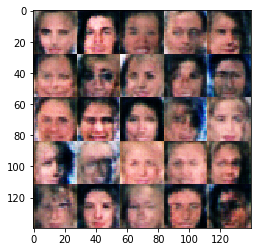

Epoch 1/2 Step 2410... Discriminator Loss: 1.4200... Generator Loss: 0.6995 ... Time spent=0.0644
Epoch 1/2 Step 2420... Discriminator Loss: 1.3824... Generator Loss: 0.6740 ... Time spent=0.0649
Epoch 1/2 Step 2430... Discriminator Loss: 1.4016... Generator Loss: 0.8701 ... Time spent=0.0638
Epoch 1/2 Step 2440... Discriminator Loss: 1.2908... Generator Loss: 0.7389 ... Time spent=0.0635
Epoch 1/2 Step 2450... Discriminator Loss: 1.5016... Generator Loss: 0.6633 ... Time spent=0.0640
Epoch 1/2 Step 2460... Discriminator Loss: 1.4465... Generator Loss: 0.7570 ... Time spent=0.0635
Epoch 1/2 Step 2470... Discriminator Loss: 1.4073... Generator Loss: 0.6949 ... Time spent=0.0639
Epoch 1/2 Step 2480... Discriminator Loss: 1.3034... Generator Loss: 0.7812 ... Time spent=0.0634
Epoch 1/2 Step 2490... Discriminator Loss: 1.2994... Generator Loss: 0.8540 ... Time spent=0.0634
Epoch 1/2 Step 2500... Discriminator Loss: 1.4965... Generator Loss: 0.6627 ... Time spent=0.0646
Epoch 1/2 Step 2510.

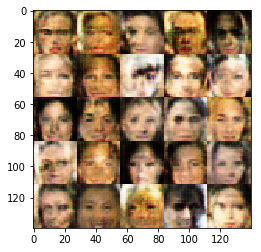

Epoch 1/2 Step 2610... Discriminator Loss: 1.3031... Generator Loss: 0.8876 ... Time spent=0.0631
Epoch 1/2 Step 2620... Discriminator Loss: 1.3795... Generator Loss: 0.6985 ... Time spent=0.0635
Epoch 1/2 Step 2630... Discriminator Loss: 1.4350... Generator Loss: 0.7787 ... Time spent=0.0638
Epoch 1/2 Step 2640... Discriminator Loss: 1.4315... Generator Loss: 0.6704 ... Time spent=0.0643
Epoch 1/2 Step 2650... Discriminator Loss: 1.4012... Generator Loss: 0.6154 ... Time spent=0.0643
Epoch 1/2 Step 2660... Discriminator Loss: 1.5166... Generator Loss: 0.7155 ... Time spent=0.0637
Epoch 1/2 Step 2670... Discriminator Loss: 1.4097... Generator Loss: 0.7921 ... Time spent=0.0639
Epoch 1/2 Step 2680... Discriminator Loss: 1.5382... Generator Loss: 0.5782 ... Time spent=0.0639
Epoch 1/2 Step 2690... Discriminator Loss: 1.5065... Generator Loss: 0.8786 ... Time spent=0.0637
Epoch 1/2 Step 2700... Discriminator Loss: 1.2660... Generator Loss: 0.6881 ... Time spent=0.0635
Epoch 1/2 Step 2710.

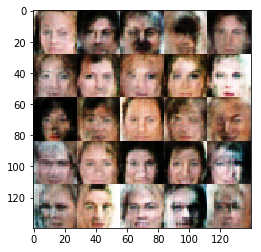

Epoch 1/2 Step 2810... Discriminator Loss: 1.4025... Generator Loss: 0.6449 ... Time spent=0.0638
Epoch 1/2 Step 2820... Discriminator Loss: 1.4994... Generator Loss: 0.7090 ... Time spent=0.0639
Epoch 1/2 Step 2830... Discriminator Loss: 1.4093... Generator Loss: 0.5990 ... Time spent=0.0636
Epoch 1/2 Step 2840... Discriminator Loss: 1.5108... Generator Loss: 0.6251 ... Time spent=0.0646
Epoch 1/2 Step 2850... Discriminator Loss: 1.4299... Generator Loss: 0.5789 ... Time spent=0.0634
Epoch 1/2 Step 2860... Discriminator Loss: 1.4597... Generator Loss: 0.6840 ... Time spent=0.0645
Epoch 1/2 Step 2870... Discriminator Loss: 1.3225... Generator Loss: 0.8438 ... Time spent=0.0644
Epoch 1/2 Step 2880... Discriminator Loss: 1.5044... Generator Loss: 0.7300 ... Time spent=0.0647
Epoch 1/2 Step 2890... Discriminator Loss: 1.4715... Generator Loss: 0.7710 ... Time spent=0.0640
Epoch 1/2 Step 2900... Discriminator Loss: 1.3838... Generator Loss: 0.8005 ... Time spent=0.0639
Epoch 1/2 Step 2910.

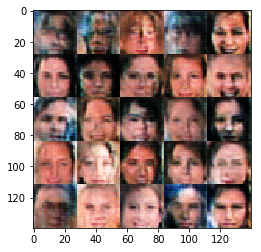

Epoch 1/2 Step 3010... Discriminator Loss: 1.4005... Generator Loss: 0.8359 ... Time spent=0.0639
Epoch 1/2 Step 3020... Discriminator Loss: 1.6151... Generator Loss: 0.7728 ... Time spent=0.0637
Epoch 1/2 Step 3030... Discriminator Loss: 1.3492... Generator Loss: 0.8403 ... Time spent=0.0651
Epoch 1/2 Step 3040... Discriminator Loss: 1.7127... Generator Loss: 0.4923 ... Time spent=0.0647
Epoch 1/2 Step 3050... Discriminator Loss: 1.4603... Generator Loss: 0.7560 ... Time spent=0.0648
Epoch 1/2 Step 3060... Discriminator Loss: 1.4772... Generator Loss: 0.7371 ... Time spent=0.0627
Epoch 1/2 Step 3070... Discriminator Loss: 1.2655... Generator Loss: 0.7096 ... Time spent=0.0641
Epoch 1/2 Step 3080... Discriminator Loss: 1.4294... Generator Loss: 0.6958 ... Time spent=0.0631
Epoch 1/2 Step 3090... Discriminator Loss: 1.2714... Generator Loss: 1.1548 ... Time spent=0.0638
Epoch 1/2 Step 3100... Discriminator Loss: 1.3457... Generator Loss: 0.7339 ... Time spent=0.0635
Epoch 1/2 Step 3110.

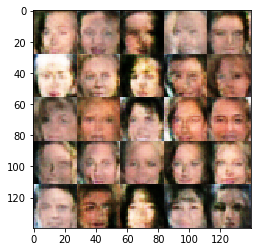

Epoch 1/2 Step 3210... Discriminator Loss: 1.3921... Generator Loss: 0.6865 ... Time spent=0.0642
Epoch 1/2 Step 3220... Discriminator Loss: 1.4045... Generator Loss: 0.6960 ... Time spent=0.0647
Epoch 1/2 Step 3230... Discriminator Loss: 1.3542... Generator Loss: 0.7594 ... Time spent=0.0642
Epoch 1/2 Step 3240... Discriminator Loss: 1.6126... Generator Loss: 0.7014 ... Time spent=0.0647
Epoch 1/2 Step 3250... Discriminator Loss: 1.5032... Generator Loss: 0.7790 ... Time spent=0.0641
Epoch 1/2 Step 3260... Discriminator Loss: 1.5348... Generator Loss: 0.6523 ... Time spent=0.0639
Epoch 1/2 Step 3270... Discriminator Loss: 1.4760... Generator Loss: 0.6153 ... Time spent=0.0639
Epoch 1/2 Step 3280... Discriminator Loss: 1.3762... Generator Loss: 0.6513 ... Time spent=0.0649
Epoch 1/2 Step 3290... Discriminator Loss: 1.5120... Generator Loss: 0.5823 ... Time spent=0.0646
Epoch 1/2 Step 3300... Discriminator Loss: 1.2843... Generator Loss: 0.8772 ... Time spent=0.0638
Epoch 1/2 Step 3310.

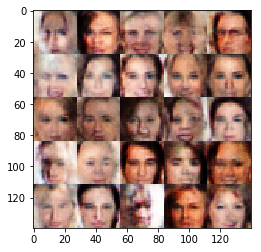

Epoch 1/2 Step 3410... Discriminator Loss: 1.3572... Generator Loss: 0.7195 ... Time spent=0.0633
Epoch 1/2 Step 3420... Discriminator Loss: 1.2718... Generator Loss: 0.7264 ... Time spent=0.0631
Epoch 1/2 Step 3430... Discriminator Loss: 1.4696... Generator Loss: 0.6926 ... Time spent=0.0629
Epoch 1/2 Step 3440... Discriminator Loss: 1.3896... Generator Loss: 0.6685 ... Time spent=0.0652
Epoch 1/2 Step 3450... Discriminator Loss: 1.3295... Generator Loss: 0.6307 ... Time spent=0.0637
Epoch 1/2 Step 3460... Discriminator Loss: 1.4097... Generator Loss: 0.7942 ... Time spent=0.0634
Epoch 1/2 Step 3470... Discriminator Loss: 1.3516... Generator Loss: 0.8146 ... Time spent=0.0643
Epoch 1/2 Step 3480... Discriminator Loss: 1.2757... Generator Loss: 0.8667 ... Time spent=0.0640
Epoch 1/2 Step 3490... Discriminator Loss: 1.3357... Generator Loss: 0.7832 ... Time spent=0.0628
Epoch 1/2 Step 3500... Discriminator Loss: 1.2807... Generator Loss: 0.7703 ... Time spent=0.0637
Epoch 1/2 Step 3510.

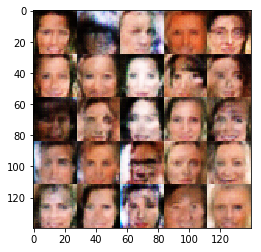

Epoch 1/2 Step 3610... Discriminator Loss: 1.3188... Generator Loss: 0.9365 ... Time spent=0.0637
Epoch 1/2 Step 3620... Discriminator Loss: 1.4482... Generator Loss: 0.6581 ... Time spent=0.0642
Epoch 1/2 Step 3630... Discriminator Loss: 1.5232... Generator Loss: 0.6967 ... Time spent=0.0640
Epoch 1/2 Step 3640... Discriminator Loss: 1.3135... Generator Loss: 0.6110 ... Time spent=0.0635
Epoch 1/2 Step 3650... Discriminator Loss: 1.4472... Generator Loss: 0.7573 ... Time spent=0.0633
Epoch 1/2 Step 3660... Discriminator Loss: 1.3607... Generator Loss: 0.7101 ... Time spent=0.0634
Epoch 1/2 Step 3670... Discriminator Loss: 1.5290... Generator Loss: 0.6578 ... Time spent=0.0641
Epoch 1/2 Step 3680... Discriminator Loss: 1.5768... Generator Loss: 0.6649 ... Time spent=0.0643
Epoch 1/2 Step 3690... Discriminator Loss: 1.4372... Generator Loss: 0.6865 ... Time spent=0.0642
Epoch 1/2 Step 3700... Discriminator Loss: 1.4210... Generator Loss: 0.6351 ... Time spent=0.0631
Epoch 1/2 Step 3710.

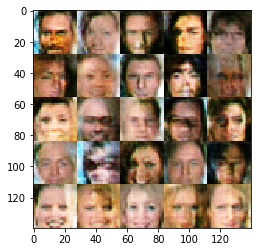

Epoch 1/2 Step 3810... Discriminator Loss: 1.2175... Generator Loss: 0.7164 ... Time spent=0.0633
Epoch 1/2 Step 3820... Discriminator Loss: 1.2671... Generator Loss: 0.7466 ... Time spent=0.0640
Epoch 1/2 Step 3830... Discriminator Loss: 1.4292... Generator Loss: 0.7910 ... Time spent=0.0636
Epoch 1/2 Step 3840... Discriminator Loss: 1.2934... Generator Loss: 0.7587 ... Time spent=0.0640
Epoch 1/2 Step 3850... Discriminator Loss: 1.3374... Generator Loss: 0.6752 ... Time spent=0.0633
Epoch 1/2 Step 3860... Discriminator Loss: 1.4392... Generator Loss: 0.6967 ... Time spent=0.0634
Epoch 1/2 Step 3870... Discriminator Loss: 1.4138... Generator Loss: 0.6916 ... Time spent=0.0633
Epoch 1/2 Step 3880... Discriminator Loss: 1.2389... Generator Loss: 0.8454 ... Time spent=0.0627
Epoch 1/2 Step 3890... Discriminator Loss: 1.7707... Generator Loss: 0.5897 ... Time spent=0.0637
Epoch 1/2 Step 3900... Discriminator Loss: 1.3730... Generator Loss: 0.8004 ... Time spent=0.0640
Epoch 1/2 Step 3910.

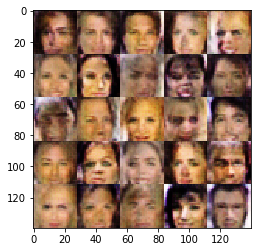

Epoch 1/2 Step 4010... Discriminator Loss: 1.3507... Generator Loss: 0.6430 ... Time spent=0.0640
Epoch 1/2 Step 4020... Discriminator Loss: 1.3598... Generator Loss: 0.8354 ... Time spent=0.0642
Epoch 1/2 Step 4030... Discriminator Loss: 1.3571... Generator Loss: 0.8300 ... Time spent=0.0637
Epoch 1/2 Step 4040... Discriminator Loss: 1.3805... Generator Loss: 0.8102 ... Time spent=0.0646
Epoch 1/2 Step 4050... Discriminator Loss: 1.5640... Generator Loss: 0.5523 ... Time spent=0.0656
Epoch 1/2 Step 4060... Discriminator Loss: 1.4646... Generator Loss: 0.7136 ... Time spent=0.0632
Epoch 1/2 Step 4070... Discriminator Loss: 1.2427... Generator Loss: 0.8797 ... Time spent=0.0633
Epoch 1/2 Step 4080... Discriminator Loss: 1.3747... Generator Loss: 0.8088 ... Time spent=0.0635
Epoch 1/2 Step 4090... Discriminator Loss: 1.5070... Generator Loss: 0.8074 ... Time spent=0.0639
Epoch 1/2 Step 4100... Discriminator Loss: 1.4534... Generator Loss: 0.7319 ... Time spent=0.0643
Epoch 1/2 Step 4110.

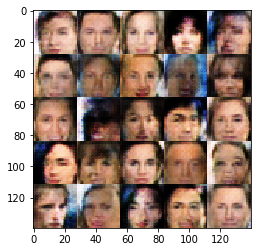

Epoch 1/2 Step 4210... Discriminator Loss: 1.4709... Generator Loss: 0.6315 ... Time spent=0.0637
Epoch 1/2 Step 4220... Discriminator Loss: 1.4894... Generator Loss: 0.8136 ... Time spent=0.0632
Epoch 1/2 Step 4230... Discriminator Loss: 1.3158... Generator Loss: 0.8134 ... Time spent=0.0638
Epoch 1/2 Step 4240... Discriminator Loss: 1.3647... Generator Loss: 0.6711 ... Time spent=0.0632
Epoch 1/2 Step 4250... Discriminator Loss: 1.4117... Generator Loss: 0.7616 ... Time spent=0.0645
Epoch 1/2 Step 4260... Discriminator Loss: 1.3279... Generator Loss: 0.8708 ... Time spent=0.0639
Epoch 1/2 Step 4270... Discriminator Loss: 1.2967... Generator Loss: 1.0202 ... Time spent=0.0633
Epoch 1/2 Step 4280... Discriminator Loss: 1.2789... Generator Loss: 0.7425 ... Time spent=0.0646
Epoch 1/2 Step 4290... Discriminator Loss: 1.3260... Generator Loss: 0.7700 ... Time spent=0.0649
Epoch 1/2 Step 4300... Discriminator Loss: 1.3008... Generator Loss: 0.7600 ... Time spent=0.0635
Epoch 1/2 Step 4310.

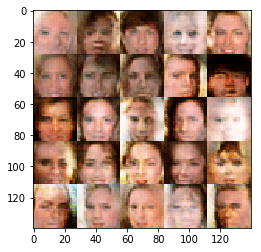

Epoch 1/2 Step 4410... Discriminator Loss: 1.2871... Generator Loss: 0.7549 ... Time spent=0.0636
Epoch 1/2 Step 4420... Discriminator Loss: 1.4217... Generator Loss: 0.6457 ... Time spent=0.0634
Epoch 1/2 Step 4430... Discriminator Loss: 1.3396... Generator Loss: 0.7720 ... Time spent=0.0634
Epoch 1/2 Step 4440... Discriminator Loss: 1.4502... Generator Loss: 0.6440 ... Time spent=0.0643
Epoch 1/2 Step 4450... Discriminator Loss: 1.3454... Generator Loss: 0.7399 ... Time spent=0.0638
Epoch 1/2 Step 4460... Discriminator Loss: 1.3294... Generator Loss: 0.7448 ... Time spent=0.0650
Epoch 1/2 Step 4470... Discriminator Loss: 1.4051... Generator Loss: 0.6508 ... Time spent=0.0633
Epoch 1/2 Step 4480... Discriminator Loss: 1.2798... Generator Loss: 0.7765 ... Time spent=0.0638
Epoch 1/2 Step 4490... Discriminator Loss: 1.4597... Generator Loss: 0.6534 ... Time spent=0.0632
Epoch 1/2 Step 4500... Discriminator Loss: 1.5097... Generator Loss: 0.7661 ... Time spent=0.0636
Epoch 1/2 Step 4510.

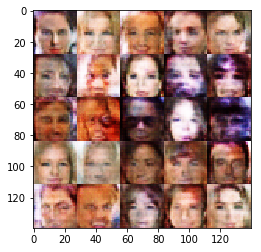

Epoch 1/2 Step 4610... Discriminator Loss: 1.4644... Generator Loss: 0.6812 ... Time spent=0.0644
Epoch 1/2 Step 4620... Discriminator Loss: 1.4114... Generator Loss: 0.7893 ... Time spent=0.0647
Epoch 1/2 Step 4630... Discriminator Loss: 1.5276... Generator Loss: 0.6174 ... Time spent=0.0642
Epoch 1/2 Step 4640... Discriminator Loss: 1.2943... Generator Loss: 0.7429 ... Time spent=0.0671
Epoch 1/2 Step 4650... Discriminator Loss: 1.4724... Generator Loss: 0.7091 ... Time spent=0.0634
Epoch 1/2 Step 4660... Discriminator Loss: 1.3560... Generator Loss: 0.6473 ... Time spent=0.0645
Epoch 1/2 Step 4670... Discriminator Loss: 1.4381... Generator Loss: 0.7368 ... Time spent=0.0641
Epoch 1/2 Step 4680... Discriminator Loss: 1.3301... Generator Loss: 0.6450 ... Time spent=0.0636
Epoch 1/2 Step 4690... Discriminator Loss: 1.3800... Generator Loss: 0.6333 ... Time spent=0.0664
Epoch 1/2 Step 4700... Discriminator Loss: 1.2621... Generator Loss: 0.7414 ... Time spent=0.0639
Epoch 1/2 Step 4710.

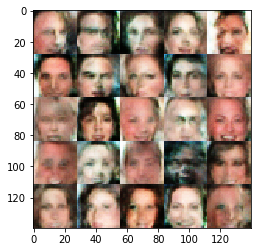

Epoch 1/2 Step 4810... Discriminator Loss: 1.3305... Generator Loss: 0.8399 ... Time spent=0.0630
Epoch 1/2 Step 4820... Discriminator Loss: 1.3970... Generator Loss: 0.7185 ... Time spent=0.0645
Epoch 1/2 Step 4830... Discriminator Loss: 1.3595... Generator Loss: 0.6070 ... Time spent=0.0636
Epoch 1/2 Step 4840... Discriminator Loss: 1.4970... Generator Loss: 0.8076 ... Time spent=0.0635
Epoch 1/2 Step 4850... Discriminator Loss: 1.6399... Generator Loss: 0.5441 ... Time spent=0.0642
Epoch 1/2 Step 4860... Discriminator Loss: 1.4023... Generator Loss: 0.7278 ... Time spent=0.0640
Epoch 1/2 Step 4870... Discriminator Loss: 1.3700... Generator Loss: 0.6144 ... Time spent=0.0635
Epoch 1/2 Step 4880... Discriminator Loss: 1.3970... Generator Loss: 0.6459 ... Time spent=0.0638
Epoch 1/2 Step 4890... Discriminator Loss: 1.2867... Generator Loss: 0.7711 ... Time spent=0.0636
Epoch 1/2 Step 4900... Discriminator Loss: 1.3698... Generator Loss: 0.7285 ... Time spent=0.0634
Epoch 1/2 Step 4910.

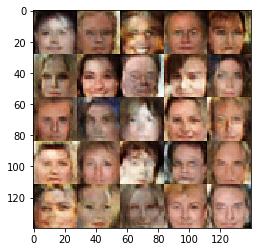

Epoch 1/2 Step 5010... Discriminator Loss: 1.3727... Generator Loss: 0.6611 ... Time spent=0.0634
Epoch 1/2 Step 5020... Discriminator Loss: 1.3338... Generator Loss: 0.6973 ... Time spent=0.0650
Epoch 1/2 Step 5030... Discriminator Loss: 1.4200... Generator Loss: 0.6679 ... Time spent=0.0641
Epoch 1/2 Step 5040... Discriminator Loss: 1.3485... Generator Loss: 0.7460 ... Time spent=0.0641
Epoch 1/2 Step 5050... Discriminator Loss: 1.4415... Generator Loss: 0.6117 ... Time spent=0.0642
Epoch 1/2 Step 5060... Discriminator Loss: 1.4589... Generator Loss: 0.6051 ... Time spent=0.0638
Epoch 1/2 Step 5070... Discriminator Loss: 1.3376... Generator Loss: 0.7278 ... Time spent=0.0659
Epoch 1/2 Step 5080... Discriminator Loss: 1.4936... Generator Loss: 0.6233 ... Time spent=0.0639
Epoch 1/2 Step 5090... Discriminator Loss: 1.4502... Generator Loss: 0.6607 ... Time spent=0.0635
Epoch 1/2 Step 5100... Discriminator Loss: 1.4665... Generator Loss: 0.6665 ... Time spent=0.0640
Epoch 1/2 Step 5110.

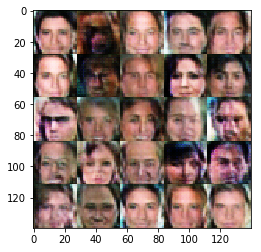

Epoch 1/2 Step 5210... Discriminator Loss: 1.4262... Generator Loss: 0.7183 ... Time spent=0.0633
Epoch 1/2 Step 5220... Discriminator Loss: 1.3879... Generator Loss: 0.7622 ... Time spent=0.0634
Epoch 1/2 Step 5230... Discriminator Loss: 1.3067... Generator Loss: 0.6808 ... Time spent=0.0640
Epoch 1/2 Step 5240... Discriminator Loss: 1.4620... Generator Loss: 0.6126 ... Time spent=0.0622
Epoch 1/2 Step 5250... Discriminator Loss: 1.3664... Generator Loss: 0.6691 ... Time spent=0.0640
Epoch 1/2 Step 5260... Discriminator Loss: 1.5261... Generator Loss: 0.5880 ... Time spent=0.0635
Epoch 1/2 Step 5270... Discriminator Loss: 1.3469... Generator Loss: 0.7279 ... Time spent=0.0638
Epoch 1/2 Step 5280... Discriminator Loss: 1.2314... Generator Loss: 0.9687 ... Time spent=0.0634
Epoch 1/2 Step 5290... Discriminator Loss: 1.1980... Generator Loss: 1.0589 ... Time spent=0.0640
Epoch 1/2 Step 5300... Discriminator Loss: 1.4671... Generator Loss: 0.6707 ... Time spent=0.0637
Epoch 1/2 Step 5310.

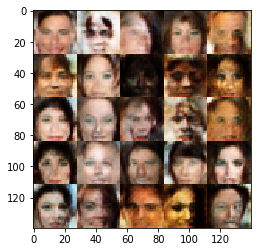

Epoch 1/2 Step 5410... Discriminator Loss: 1.4041... Generator Loss: 0.6117 ... Time spent=0.0643
Epoch 1/2 Step 5420... Discriminator Loss: 1.4377... Generator Loss: 0.7683 ... Time spent=0.0643
Epoch 1/2 Step 5430... Discriminator Loss: 1.4557... Generator Loss: 0.7911 ... Time spent=0.0627
Epoch 1/2 Step 5440... Discriminator Loss: 1.5102... Generator Loss: 0.5817 ... Time spent=0.0639
Epoch 1/2 Step 5450... Discriminator Loss: 1.3444... Generator Loss: 0.8547 ... Time spent=0.0628
Epoch 1/2 Step 5460... Discriminator Loss: 1.5915... Generator Loss: 0.5609 ... Time spent=0.0636
Epoch 1/2 Step 5470... Discriminator Loss: 1.3814... Generator Loss: 0.7919 ... Time spent=0.0642
Epoch 1/2 Step 5480... Discriminator Loss: 1.4087... Generator Loss: 0.7402 ... Time spent=0.0641
Epoch 1/2 Step 5490... Discriminator Loss: 1.3668... Generator Loss: 0.7061 ... Time spent=0.0630
Epoch 1/2 Step 5500... Discriminator Loss: 1.4267... Generator Loss: 0.5586 ... Time spent=0.0629
Epoch 1/2 Step 5510.

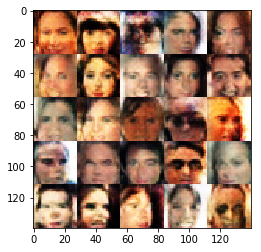

Epoch 1/2 Step 5610... Discriminator Loss: 1.4744... Generator Loss: 0.6439 ... Time spent=0.0634
Epoch 1/2 Step 5620... Discriminator Loss: 1.3776... Generator Loss: 0.6589 ... Time spent=0.0641
Epoch 1/2 Step 5630... Discriminator Loss: 1.4060... Generator Loss: 0.6531 ... Time spent=0.0638
Epoch 1/2 Step 5640... Discriminator Loss: 1.5072... Generator Loss: 0.6908 ... Time spent=0.0637
Epoch 1/2 Step 5650... Discriminator Loss: 1.5050... Generator Loss: 0.7204 ... Time spent=0.0699
Epoch 1/2 Step 5660... Discriminator Loss: 1.2192... Generator Loss: 0.7243 ... Time spent=0.0644
Epoch 1/2 Step 5670... Discriminator Loss: 1.4959... Generator Loss: 0.6217 ... Time spent=0.0643
Epoch 1/2 Step 5680... Discriminator Loss: 1.5129... Generator Loss: 0.5498 ... Time spent=0.0647
Epoch 1/2 Step 5690... Discriminator Loss: 1.4071... Generator Loss: 0.6518 ... Time spent=0.0644
Epoch 1/2 Step 5700... Discriminator Loss: 1.3876... Generator Loss: 0.7197 ... Time spent=0.0639
Epoch 1/2 Step 5710.

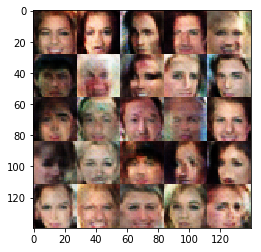

Epoch 1/2 Step 5810... Discriminator Loss: 1.3883... Generator Loss: 0.6044 ... Time spent=0.0639
Epoch 1/2 Step 5820... Discriminator Loss: 1.6354... Generator Loss: 0.6048 ... Time spent=0.0647
Epoch 1/2 Step 5830... Discriminator Loss: 1.3316... Generator Loss: 0.7435 ... Time spent=0.0635
Epoch 1/2 Step 5840... Discriminator Loss: 1.3790... Generator Loss: 0.7024 ... Time spent=0.0633
Epoch 1/2 Step 5850... Discriminator Loss: 1.3266... Generator Loss: 0.7181 ... Time spent=0.0636
Epoch 1/2 Step 5860... Discriminator Loss: 1.2759... Generator Loss: 0.7895 ... Time spent=0.0645
Epoch 1/2 Step 5870... Discriminator Loss: 1.4077... Generator Loss: 0.6950 ... Time spent=0.0640
Epoch 1/2 Step 5880... Discriminator Loss: 1.5307... Generator Loss: 0.5481 ... Time spent=0.0638
Epoch 1/2 Step 5890... Discriminator Loss: 1.3268... Generator Loss: 0.6862 ... Time spent=0.0640
Epoch 1/2 Step 5900... Discriminator Loss: 1.2433... Generator Loss: 0.7911 ... Time spent=0.0638
Epoch 1/2 Step 5910.

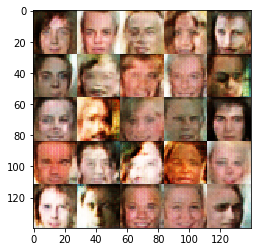

Epoch 1/2 Step 6010... Discriminator Loss: 1.3615... Generator Loss: 0.6391 ... Time spent=0.0636
Epoch 1/2 Step 6020... Discriminator Loss: 1.3623... Generator Loss: 0.6769 ... Time spent=0.0646
Epoch 1/2 Step 6030... Discriminator Loss: 1.2825... Generator Loss: 0.7389 ... Time spent=0.0673
Epoch 1/2 Step 6040... Discriminator Loss: 1.3052... Generator Loss: 0.8098 ... Time spent=0.0643
Epoch 1/2 Step 6050... Discriminator Loss: 1.2847... Generator Loss: 0.7590 ... Time spent=0.0637
Epoch 1/2 Step 6060... Discriminator Loss: 1.3657... Generator Loss: 0.6546 ... Time spent=0.0649
Epoch 1/2 Step 6070... Discriminator Loss: 1.3923... Generator Loss: 0.6632 ... Time spent=0.0640
Epoch 1/2 Step 6080... Discriminator Loss: 1.6010... Generator Loss: 0.5225 ... Time spent=0.0630
Epoch 1/2 Step 6090... Discriminator Loss: 1.2708... Generator Loss: 0.8269 ... Time spent=0.0642
Epoch 1/2 Step 6100... Discriminator Loss: 1.4148... Generator Loss: 0.6387 ... Time spent=0.0643
Epoch 1/2 Step 6110.

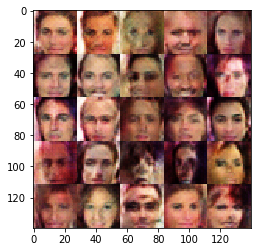

Epoch 1/2 Step 6210... Discriminator Loss: 1.3753... Generator Loss: 0.6924 ... Time spent=0.0644
Epoch 1/2 Step 6220... Discriminator Loss: 1.3201... Generator Loss: 0.8392 ... Time spent=0.0631
Epoch 1/2 Step 6230... Discriminator Loss: 1.3035... Generator Loss: 0.7426 ... Time spent=0.0642
Epoch 1/2 Step 6240... Discriminator Loss: 1.2179... Generator Loss: 0.6845 ... Time spent=0.0638
Epoch 1/2 Step 6250... Discriminator Loss: 1.2402... Generator Loss: 0.9246 ... Time spent=0.0641
Epoch 1/2 Step 6260... Discriminator Loss: 1.3743... Generator Loss: 0.7792 ... Time spent=0.0637
Epoch 1/2 Step 6270... Discriminator Loss: 1.3934... Generator Loss: 0.6836 ... Time spent=0.0632
Epoch 1/2 Step 6280... Discriminator Loss: 1.5313... Generator Loss: 0.5764 ... Time spent=0.0642
Epoch 1/2 Step 6290... Discriminator Loss: 1.2439... Generator Loss: 0.7562 ... Time spent=0.0658
Epoch 1/2 Step 6300... Discriminator Loss: 1.4437... Generator Loss: 0.7178 ... Time spent=0.0640
Epoch 1/2 Step 6310.

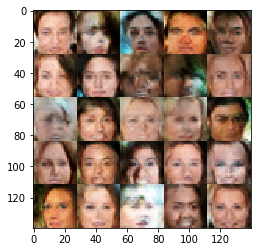

Epoch 1/2 Step 6410... Discriminator Loss: 1.4815... Generator Loss: 0.5847 ... Time spent=0.0639
Epoch 1/2 Step 6420... Discriminator Loss: 1.5049... Generator Loss: 0.5459 ... Time spent=0.0640
Epoch 1/2 Step 6430... Discriminator Loss: 1.4196... Generator Loss: 0.7385 ... Time spent=0.0640
Epoch 1/2 Step 6440... Discriminator Loss: 1.4194... Generator Loss: 0.7036 ... Time spent=0.0635
Epoch 1/2 Step 6450... Discriminator Loss: 1.1587... Generator Loss: 0.8708 ... Time spent=0.0651
Epoch 1/2 Step 6460... Discriminator Loss: 1.5033... Generator Loss: 0.5988 ... Time spent=0.0628
Epoch 1/2 Step 6470... Discriminator Loss: 1.2864... Generator Loss: 0.6950 ... Time spent=0.0647
Epoch 1/2 Step 6480... Discriminator Loss: 1.3893... Generator Loss: 0.5860 ... Time spent=0.0634
Epoch 1/2 Step 6490... Discriminator Loss: 1.3421... Generator Loss: 0.7452 ... Time spent=0.0636
Epoch 1/2 Step 6500... Discriminator Loss: 1.3089... Generator Loss: 0.7044 ... Time spent=0.0643
Epoch 1/2 Step 6510.

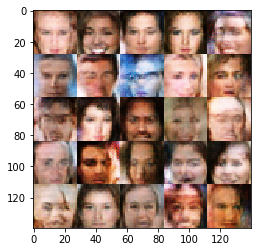

Epoch 1/2 Step 6610... Discriminator Loss: 1.3671... Generator Loss: 0.6799 ... Time spent=0.0638
Epoch 1/2 Step 6620... Discriminator Loss: 1.3630... Generator Loss: 0.8693 ... Time spent=0.0643
Epoch 1/2 Step 6630... Discriminator Loss: 1.4335... Generator Loss: 0.6675 ... Time spent=0.0641
Epoch 1/2 Step 6640... Discriminator Loss: 1.4166... Generator Loss: 0.6095 ... Time spent=0.0640
Epoch 1/2 Step 6650... Discriminator Loss: 1.1909... Generator Loss: 0.8894 ... Time spent=0.0649
Epoch 1/2 Step 6660... Discriminator Loss: 1.2548... Generator Loss: 0.7141 ... Time spent=0.0641
Epoch 1/2 Step 6670... Discriminator Loss: 1.3012... Generator Loss: 0.7967 ... Time spent=0.0637
Epoch 1/2 Step 6680... Discriminator Loss: 1.3765... Generator Loss: 0.7565 ... Time spent=0.0636
Epoch 1/2 Step 6690... Discriminator Loss: 1.1450... Generator Loss: 0.9586 ... Time spent=0.0659
Epoch 1/2 Step 6700... Discriminator Loss: 1.3063... Generator Loss: 0.8174 ... Time spent=0.0639
Epoch 1/2 Step 6710.

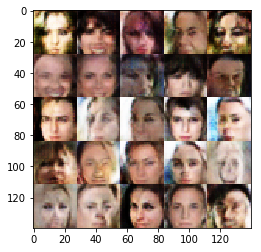

Epoch 1/2 Step 6810... Discriminator Loss: 1.3934... Generator Loss: 0.7113 ... Time spent=0.0634
Epoch 1/2 Step 6820... Discriminator Loss: 1.3545... Generator Loss: 0.7345 ... Time spent=0.0635
Epoch 1/2 Step 6830... Discriminator Loss: 1.4474... Generator Loss: 0.7055 ... Time spent=0.0638
Epoch 1/2 Step 6840... Discriminator Loss: 1.3534... Generator Loss: 0.6300 ... Time spent=0.0635
Epoch 1/2 Step 6850... Discriminator Loss: 1.4464... Generator Loss: 0.6301 ... Time spent=0.0638
Epoch 1/2 Step 6860... Discriminator Loss: 1.3516... Generator Loss: 0.7891 ... Time spent=0.0650
Epoch 1/2 Step 6870... Discriminator Loss: 1.4022... Generator Loss: 0.6892 ... Time spent=0.0638
Epoch 1/2 Step 6880... Discriminator Loss: 1.3913... Generator Loss: 0.6176 ... Time spent=0.0639
Epoch 1/2 Step 6890... Discriminator Loss: 1.3651... Generator Loss: 0.7459 ... Time spent=0.0637
Epoch 1/2 Step 6900... Discriminator Loss: 1.3497... Generator Loss: 0.7445 ... Time spent=0.0655
Epoch 1/2 Step 6910.

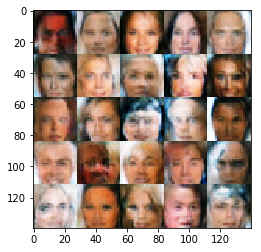

Epoch 1/2 Step 7010... Discriminator Loss: 1.4750... Generator Loss: 0.7528 ... Time spent=0.0645
Epoch 1/2 Step 7020... Discriminator Loss: 1.3348... Generator Loss: 0.7106 ... Time spent=0.0638
Epoch 1/2 Step 7030... Discriminator Loss: 1.3106... Generator Loss: 0.7389 ... Time spent=0.0640
Epoch 1/2 Step 7040... Discriminator Loss: 1.3333... Generator Loss: 0.7142 ... Time spent=0.0633
Epoch 1/2 Step 7050... Discriminator Loss: 1.3253... Generator Loss: 0.6829 ... Time spent=0.0636
Epoch 1/2 Step 7060... Discriminator Loss: 1.4693... Generator Loss: 0.6269 ... Time spent=0.0629
Epoch 1/2 Step 7070... Discriminator Loss: 1.3600... Generator Loss: 0.7059 ... Time spent=0.0629
Epoch 1/2 Step 7080... Discriminator Loss: 1.4392... Generator Loss: 0.6606 ... Time spent=0.0645
Epoch 1/2 Step 7090... Discriminator Loss: 1.3954... Generator Loss: 0.6110 ... Time spent=0.0635
Epoch 1/2 Step 7100... Discriminator Loss: 1.4327... Generator Loss: 0.7159 ... Time spent=0.0671
Epoch 1/2 Step 7110.

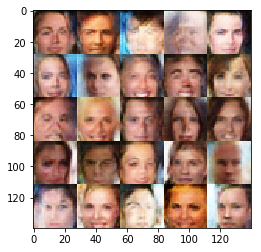

Epoch 1/2 Step 7210... Discriminator Loss: 1.3654... Generator Loss: 0.7008 ... Time spent=0.0638
Epoch 1/2 Step 7220... Discriminator Loss: 1.4521... Generator Loss: 0.7018 ... Time spent=0.0640
Epoch 1/2 Step 7230... Discriminator Loss: 1.3950... Generator Loss: 0.7039 ... Time spent=0.0645
Epoch 1/2 Step 7240... Discriminator Loss: 1.2852... Generator Loss: 0.8575 ... Time spent=0.0641
Epoch 1/2 Step 7250... Discriminator Loss: 1.6500... Generator Loss: 0.4882 ... Time spent=0.0639
Epoch 1/2 Step 7260... Discriminator Loss: 1.2482... Generator Loss: 0.8759 ... Time spent=0.0644
Epoch 1/2 Step 7270... Discriminator Loss: 1.3214... Generator Loss: 0.7158 ... Time spent=0.0635
Epoch 1/2 Step 7280... Discriminator Loss: 1.4410... Generator Loss: 0.6217 ... Time spent=0.0636
Epoch 1/2 Step 7290... Discriminator Loss: 1.4920... Generator Loss: 0.6193 ... Time spent=0.0629
Epoch 1/2 Step 7300... Discriminator Loss: 1.1244... Generator Loss: 0.8680 ... Time spent=0.0633
Epoch 1/2 Step 7310.

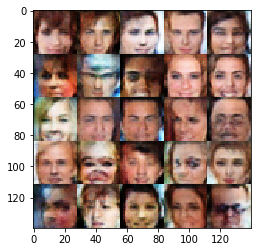

Epoch 1/2 Step 7410... Discriminator Loss: 1.4429... Generator Loss: 0.6582 ... Time spent=0.0634
Epoch 1/2 Step 7420... Discriminator Loss: 1.3383... Generator Loss: 0.6818 ... Time spent=0.0641
Epoch 1/2 Step 7430... Discriminator Loss: 1.4352... Generator Loss: 0.6773 ... Time spent=0.0635
Epoch 1/2 Step 7440... Discriminator Loss: 1.2037... Generator Loss: 0.8985 ... Time spent=0.0634
Epoch 1/2 Step 7450... Discriminator Loss: 1.3265... Generator Loss: 0.7101 ... Time spent=0.0641
Epoch 1/2 Step 7460... Discriminator Loss: 1.5337... Generator Loss: 0.5642 ... Time spent=0.0639
Epoch 1/2 Step 7470... Discriminator Loss: 1.1500... Generator Loss: 0.9204 ... Time spent=0.0638
Epoch 1/2 Step 7480... Discriminator Loss: 1.2729... Generator Loss: 0.7973 ... Time spent=0.0639
Epoch 1/2 Step 7490... Discriminator Loss: 1.5093... Generator Loss: 0.6702 ... Time spent=0.0635
Epoch 1/2 Step 7500... Discriminator Loss: 1.3707... Generator Loss: 0.6571 ... Time spent=0.0641
Epoch 1/2 Step 7510.

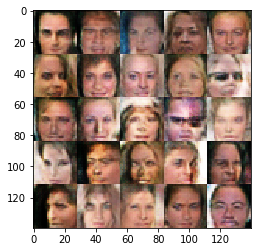

Epoch 1/2 Step 7610... Discriminator Loss: 1.2960... Generator Loss: 0.7361 ... Time spent=0.0628
Epoch 1/2 Step 7620... Discriminator Loss: 1.3439... Generator Loss: 0.6579 ... Time spent=0.0643
Epoch 1/2 Step 7630... Discriminator Loss: 1.4380... Generator Loss: 0.7132 ... Time spent=0.0643
Epoch 1/2 Step 7640... Discriminator Loss: 1.3968... Generator Loss: 0.6749 ... Time spent=0.0634
Epoch 1/2 Step 7650... Discriminator Loss: 1.4261... Generator Loss: 0.7358 ... Time spent=0.0638
Epoch 1/2 Step 7660... Discriminator Loss: 1.4519... Generator Loss: 0.5792 ... Time spent=0.0646
Epoch 1/2 Step 7670... Discriminator Loss: 1.6240... Generator Loss: 0.6081 ... Time spent=0.0633
Epoch 1/2 Step 7680... Discriminator Loss: 1.4090... Generator Loss: 0.6393 ... Time spent=0.0637
Epoch 1/2 Step 7690... Discriminator Loss: 1.4136... Generator Loss: 0.6745 ... Time spent=0.0653
Epoch 1/2 Step 7700... Discriminator Loss: 1.3338... Generator Loss: 0.7986 ... Time spent=0.0642
Epoch 1/2 Step 7710.

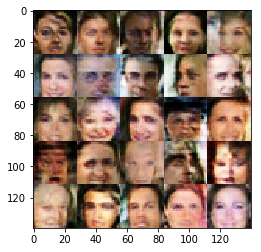

Epoch 1/2 Step 7810... Discriminator Loss: 1.4285... Generator Loss: 0.6672 ... Time spent=0.0639
Epoch 1/2 Step 7820... Discriminator Loss: 1.3904... Generator Loss: 0.7376 ... Time spent=0.0647
Epoch 1/2 Step 7830... Discriminator Loss: 1.4347... Generator Loss: 0.6598 ... Time spent=0.0641
Epoch 1/2 Step 7840... Discriminator Loss: 1.3953... Generator Loss: 0.7565 ... Time spent=0.0653
Epoch 1/2 Step 7850... Discriminator Loss: 1.4659... Generator Loss: 0.6740 ... Time spent=0.0632
Epoch 1/2 Step 7860... Discriminator Loss: 1.2813... Generator Loss: 0.7729 ... Time spent=0.0649
Epoch 1/2 Step 7870... Discriminator Loss: 1.2650... Generator Loss: 0.7795 ... Time spent=0.0629
Epoch 1/2 Step 7880... Discriminator Loss: 1.4408... Generator Loss: 0.7150 ... Time spent=0.0631
Epoch 1/2 Step 7890... Discriminator Loss: 1.4023... Generator Loss: 0.7118 ... Time spent=0.0639
Epoch 1/2 Step 7900... Discriminator Loss: 1.3498... Generator Loss: 0.6843 ... Time spent=0.0638
Epoch 1/2 Step 7910.

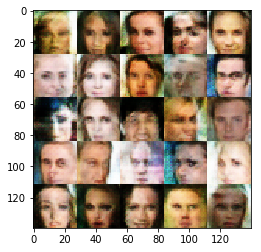

Epoch 1/2 Step 8010... Discriminator Loss: 1.4636... Generator Loss: 0.6723 ... Time spent=0.0649
Epoch 1/2 Step 8020... Discriminator Loss: 1.3770... Generator Loss: 0.6388 ... Time spent=0.0633
Epoch 1/2 Step 8030... Discriminator Loss: 1.3499... Generator Loss: 0.8230 ... Time spent=0.0631
Epoch 1/2 Step 8040... Discriminator Loss: 1.3097... Generator Loss: 0.8372 ... Time spent=0.0671
Epoch 1/2 Step 8050... Discriminator Loss: 1.3624... Generator Loss: 0.7752 ... Time spent=0.0636
Epoch 1/2 Step 8060... Discriminator Loss: 1.4557... Generator Loss: 0.7068 ... Time spent=0.0642
Epoch 1/2 Step 8070... Discriminator Loss: 1.4293... Generator Loss: 0.6077 ... Time spent=0.0650
Epoch 1/2 Step 8080... Discriminator Loss: 1.3568... Generator Loss: 0.7062 ... Time spent=0.0639
Epoch 1/2 Step 8090... Discriminator Loss: 1.2567... Generator Loss: 1.0108 ... Time spent=0.0639
Epoch 1/2 Step 8100... Discriminator Loss: 1.4545... Generator Loss: 0.5124 ... Time spent=0.0649
Epoch 1/2 Step 8110.

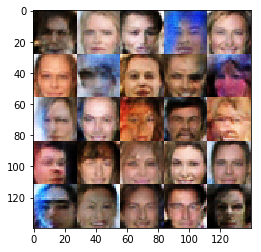

Epoch 1/2 Step 8210... Discriminator Loss: 1.2690... Generator Loss: 0.7165 ... Time spent=0.0637
Epoch 1/2 Step 8220... Discriminator Loss: 1.3781... Generator Loss: 0.6059 ... Time spent=0.0627
Epoch 1/2 Step 8230... Discriminator Loss: 1.3425... Generator Loss: 0.7820 ... Time spent=0.0634
Epoch 1/2 Step 8240... Discriminator Loss: 1.5327... Generator Loss: 0.5651 ... Time spent=0.0641
Epoch 1/2 Step 8250... Discriminator Loss: 1.3836... Generator Loss: 0.6821 ... Time spent=0.0636
Epoch 1/2 Step 8260... Discriminator Loss: 1.6085... Generator Loss: 0.5415 ... Time spent=0.0641
Epoch 1/2 Step 8270... Discriminator Loss: 1.4431... Generator Loss: 0.6989 ... Time spent=0.0642
Epoch 1/2 Step 8280... Discriminator Loss: 1.3718... Generator Loss: 0.7104 ... Time spent=0.0637
Epoch 1/2 Step 8290... Discriminator Loss: 1.2698... Generator Loss: 0.7768 ... Time spent=0.0641
Epoch 1/2 Step 8300... Discriminator Loss: 1.3156... Generator Loss: 0.7430 ... Time spent=0.0637
Epoch 1/2 Step 8310.

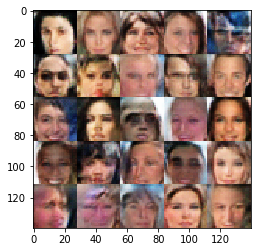

Epoch 1/2 Step 8410... Discriminator Loss: 1.4274... Generator Loss: 0.6863 ... Time spent=0.0640
Epoch 1/2 Step 8420... Discriminator Loss: 1.4298... Generator Loss: 0.6021 ... Time spent=0.0636
Epoch 1/2 Step 8430... Discriminator Loss: 1.2887... Generator Loss: 0.7854 ... Time spent=0.0638
Epoch 1/2 Step 8440... Discriminator Loss: 1.3322... Generator Loss: 0.7766 ... Time spent=0.0637
Epoch 1/2 Step 8450... Discriminator Loss: 1.3217... Generator Loss: 0.8137 ... Time spent=0.0649
Epoch 1/2 Step 8460... Discriminator Loss: 1.5039... Generator Loss: 0.6170 ... Time spent=0.0640
Epoch 1/2 Step 8470... Discriminator Loss: 1.3124... Generator Loss: 0.7105 ... Time spent=0.0631
Epoch 1/2 Step 8480... Discriminator Loss: 1.4211... Generator Loss: 0.6248 ... Time spent=0.0642
Epoch 1/2 Step 8490... Discriminator Loss: 1.3134... Generator Loss: 0.7120 ... Time spent=0.0646
Epoch 1/2 Step 8500... Discriminator Loss: 1.3500... Generator Loss: 0.5910 ... Time spent=0.0637
Epoch 1/2 Step 8510.

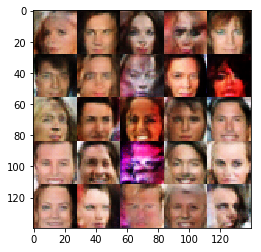

Epoch 1/2 Step 8610... Discriminator Loss: 1.4473... Generator Loss: 0.6190 ... Time spent=0.0637
Epoch 1/2 Step 8620... Discriminator Loss: 1.4053... Generator Loss: 0.6378 ... Time spent=0.0674
Epoch 1/2 Step 8630... Discriminator Loss: 1.2585... Generator Loss: 0.7784 ... Time spent=0.0633
Epoch 1/2 Step 8640... Discriminator Loss: 1.2699... Generator Loss: 0.7837 ... Time spent=0.0636
Epoch 1/2 Step 8650... Discriminator Loss: 1.4161... Generator Loss: 0.7080 ... Time spent=0.0630
Epoch 1/2 Step 8660... Discriminator Loss: 1.2324... Generator Loss: 0.8180 ... Time spent=0.0643
Epoch 1/2 Step 8670... Discriminator Loss: 1.4014... Generator Loss: 0.7032 ... Time spent=0.0631
Epoch 1/2 Step 8680... Discriminator Loss: 1.3659... Generator Loss: 0.7612 ... Time spent=0.0633
Epoch 1/2 Step 8690... Discriminator Loss: 1.2655... Generator Loss: 0.7934 ... Time spent=0.0628
Epoch 1/2 Step 8700... Discriminator Loss: 1.4224... Generator Loss: 0.6915 ... Time spent=0.0631
Epoch 1/2 Step 8710.

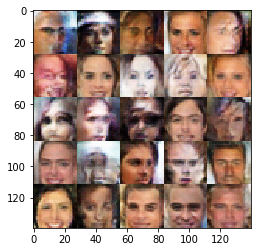

Epoch 1/2 Step 8810... Discriminator Loss: 1.4557... Generator Loss: 0.6312 ... Time spent=0.0637
Epoch 1/2 Step 8820... Discriminator Loss: 1.3499... Generator Loss: 0.7438 ... Time spent=0.0641
Epoch 1/2 Step 8830... Discriminator Loss: 1.2780... Generator Loss: 0.7910 ... Time spent=0.0655
Epoch 1/2 Step 8840... Discriminator Loss: 1.4347... Generator Loss: 0.7967 ... Time spent=0.0638
Epoch 1/2 Step 8850... Discriminator Loss: 1.5064... Generator Loss: 0.5911 ... Time spent=0.0632
Epoch 1/2 Step 8860... Discriminator Loss: 1.3222... Generator Loss: 0.8174 ... Time spent=0.0635
Epoch 1/2 Step 8870... Discriminator Loss: 1.4720... Generator Loss: 0.6370 ... Time spent=0.0634
Epoch 1/2 Step 8880... Discriminator Loss: 1.4498... Generator Loss: 0.7331 ... Time spent=0.0642
Epoch 1/2 Step 8890... Discriminator Loss: 1.4194... Generator Loss: 0.6244 ... Time spent=0.0637
Epoch 1/2 Step 8900... Discriminator Loss: 1.4227... Generator Loss: 0.7108 ... Time spent=0.0635
Epoch 1/2 Step 8910.

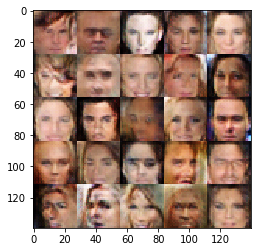

Epoch 1/2 Step 9010... Discriminator Loss: 1.3472... Generator Loss: 0.6942 ... Time spent=0.0641
Epoch 1/2 Step 9020... Discriminator Loss: 1.4895... Generator Loss: 0.7049 ... Time spent=0.0641
Epoch 1/2 Step 9030... Discriminator Loss: 1.3263... Generator Loss: 0.7151 ... Time spent=0.0641
Epoch 1/2 Step 9040... Discriminator Loss: 1.2494... Generator Loss: 0.7798 ... Time spent=0.0646
Epoch 1/2 Step 9050... Discriminator Loss: 1.3869... Generator Loss: 0.6796 ... Time spent=0.0640
Epoch 1/2 Step 9060... Discriminator Loss: 1.3689... Generator Loss: 0.6940 ... Time spent=0.0638
Epoch 1/2 Step 9070... Discriminator Loss: 1.2343... Generator Loss: 0.8754 ... Time spent=0.0638
Epoch 1/2 Step 9080... Discriminator Loss: 1.2853... Generator Loss: 0.8411 ... Time spent=0.0640
Epoch 1/2 Step 9090... Discriminator Loss: 1.2831... Generator Loss: 0.7927 ... Time spent=0.0642
Epoch 1/2 Step 9100... Discriminator Loss: 1.5131... Generator Loss: 0.6275 ... Time spent=0.0638
Epoch 1/2 Step 9110.

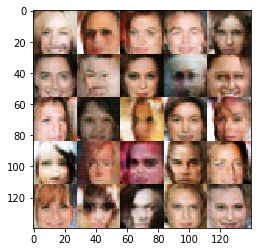

Epoch 1/2 Step 9210... Discriminator Loss: 1.3873... Generator Loss: 0.7127 ... Time spent=0.0633
Epoch 1/2 Step 9220... Discriminator Loss: 1.2727... Generator Loss: 0.8696 ... Time spent=0.0646
Epoch 1/2 Step 9230... Discriminator Loss: 1.3928... Generator Loss: 0.7160 ... Time spent=0.0650
Epoch 1/2 Step 9240... Discriminator Loss: 1.3232... Generator Loss: 0.7654 ... Time spent=0.0635
Epoch 1/2 Step 9250... Discriminator Loss: 1.2446... Generator Loss: 0.7681 ... Time spent=0.0639
Epoch 1/2 Step 9260... Discriminator Loss: 1.3166... Generator Loss: 0.6816 ... Time spent=0.0639
Epoch 1/2 Step 9270... Discriminator Loss: 1.3428... Generator Loss: 0.7708 ... Time spent=0.0644
Epoch 1/2 Step 9280... Discriminator Loss: 1.3817... Generator Loss: 0.8165 ... Time spent=0.0641
Epoch 1/2 Step 9290... Discriminator Loss: 1.2911... Generator Loss: 0.7840 ... Time spent=0.0638
Epoch 1/2 Step 9300... Discriminator Loss: 1.3488... Generator Loss: 0.7589 ... Time spent=0.0639
Epoch 1/2 Step 9310.

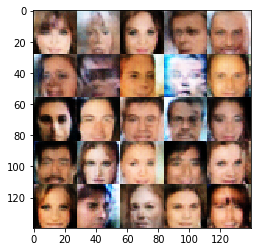

Epoch 1/2 Step 9410... Discriminator Loss: 1.2165... Generator Loss: 0.7919 ... Time spent=0.0634
Epoch 1/2 Step 9420... Discriminator Loss: 1.3967... Generator Loss: 0.7446 ... Time spent=0.0635
Epoch 1/2 Step 9430... Discriminator Loss: 1.3749... Generator Loss: 0.6669 ... Time spent=0.0644
Epoch 1/2 Step 9440... Discriminator Loss: 1.4725... Generator Loss: 0.5969 ... Time spent=0.0625
Epoch 1/2 Step 9450... Discriminator Loss: 1.5160... Generator Loss: 0.6926 ... Time spent=0.0637
Epoch 1/2 Step 9460... Discriminator Loss: 1.3971... Generator Loss: 0.7425 ... Time spent=0.0638
Epoch 1/2 Step 9470... Discriminator Loss: 1.2897... Generator Loss: 0.7565 ... Time spent=0.0649
Epoch 1/2 Step 9480... Discriminator Loss: 1.4032... Generator Loss: 0.6147 ... Time spent=0.0633
Epoch 1/2 Step 9490... Discriminator Loss: 1.1755... Generator Loss: 0.8714 ... Time spent=0.0638
Epoch 1/2 Step 9500... Discriminator Loss: 1.3736... Generator Loss: 0.6512 ... Time spent=0.0640
Epoch 1/2 Step 9510.

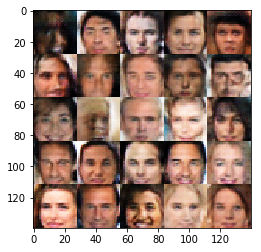

Epoch 1/2 Step 9610... Discriminator Loss: 1.4568... Generator Loss: 0.7295 ... Time spent=0.0642
Epoch 1/2 Step 9620... Discriminator Loss: 1.4238... Generator Loss: 0.5931 ... Time spent=0.0635
Epoch 1/2 Step 9630... Discriminator Loss: 1.4656... Generator Loss: 0.6600 ... Time spent=0.0651
Epoch 1/2 Step 9640... Discriminator Loss: 1.4362... Generator Loss: 0.6557 ... Time spent=0.0711
Epoch 1/2 Step 9650... Discriminator Loss: 1.2373... Generator Loss: 0.8637 ... Time spent=0.0635
Epoch 1/2 Step 9660... Discriminator Loss: 1.3244... Generator Loss: 0.7794 ... Time spent=0.0637
Epoch 1/2 Step 9670... Discriminator Loss: 1.3001... Generator Loss: 0.7920 ... Time spent=0.0647
Epoch 1/2 Step 9680... Discriminator Loss: 1.4460... Generator Loss: 0.6611 ... Time spent=0.0634
Epoch 1/2 Step 9690... Discriminator Loss: 0.9911... Generator Loss: 0.9928 ... Time spent=0.0637
Epoch 1/2 Step 9700... Discriminator Loss: 1.3912... Generator Loss: 0.7096 ... Time spent=0.0636
Epoch 1/2 Step 9710.

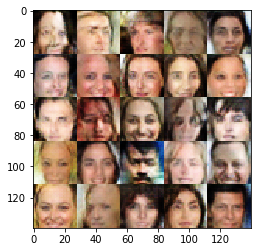

Epoch 1/2 Step 9810... Discriminator Loss: 1.3810... Generator Loss: 0.7123 ... Time spent=0.0629
Epoch 1/2 Step 9820... Discriminator Loss: 1.3430... Generator Loss: 0.7175 ... Time spent=0.0634
Epoch 1/2 Step 9830... Discriminator Loss: 1.3955... Generator Loss: 0.6745 ... Time spent=0.0641
Epoch 1/2 Step 9840... Discriminator Loss: 1.4068... Generator Loss: 0.6809 ... Time spent=0.0635
Epoch 1/2 Step 9850... Discriminator Loss: 1.4026... Generator Loss: 0.7043 ... Time spent=0.0644
Epoch 1/2 Step 9860... Discriminator Loss: 1.3826... Generator Loss: 0.7281 ... Time spent=0.0646
Epoch 1/2 Step 9870... Discriminator Loss: 1.4145... Generator Loss: 0.7304 ... Time spent=0.0636
Epoch 1/2 Step 9880... Discriminator Loss: 1.4108... Generator Loss: 0.7717 ... Time spent=0.0637
Epoch 1/2 Step 9890... Discriminator Loss: 1.2777... Generator Loss: 0.7619 ... Time spent=0.0641
Epoch 1/2 Step 9900... Discriminator Loss: 1.3263... Generator Loss: 0.7586 ... Time spent=0.0646
Epoch 1/2 Step 9910.

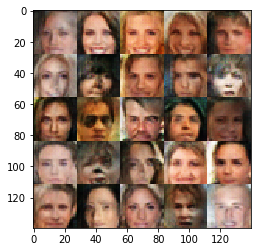

Epoch 1/2 Step 10010... Discriminator Loss: 1.4672... Generator Loss: 0.7226 ... Time spent=0.0628
Epoch 1/2 Step 10020... Discriminator Loss: 1.1827... Generator Loss: 0.9147 ... Time spent=0.0634
Epoch 1/2 Step 10030... Discriminator Loss: 1.2781... Generator Loss: 0.8751 ... Time spent=0.0647
Epoch 1/2 Step 10040... Discriminator Loss: 1.3812... Generator Loss: 0.6714 ... Time spent=0.0631
Epoch 1/2 Step 10050... Discriminator Loss: 1.3466... Generator Loss: 0.7232 ... Time spent=0.0629
Epoch 1/2 Step 10060... Discriminator Loss: 1.5746... Generator Loss: 0.5958 ... Time spent=0.0642
Epoch 1/2 Step 10070... Discriminator Loss: 1.4419... Generator Loss: 0.6637 ... Time spent=0.0634
Epoch 1/2 Step 10080... Discriminator Loss: 1.3605... Generator Loss: 0.6896 ... Time spent=0.0651
Epoch 1/2 Step 10090... Discriminator Loss: 1.3070... Generator Loss: 0.7960 ... Time spent=0.0642
Epoch 1/2 Step 10100... Discriminator Loss: 1.3141... Generator Loss: 0.7261 ... Time spent=0.0639
Epoch 1/2 

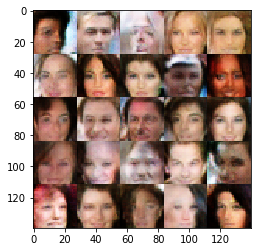

Epoch 1/2 Step 10210... Discriminator Loss: 1.4170... Generator Loss: 0.7159 ... Time spent=0.0639
Epoch 1/2 Step 10220... Discriminator Loss: 1.4246... Generator Loss: 0.6374 ... Time spent=0.0643
Epoch 1/2 Step 10230... Discriminator Loss: 1.3586... Generator Loss: 0.7451 ... Time spent=0.0628
Epoch 1/2 Step 10240... Discriminator Loss: 1.3810... Generator Loss: 0.6928 ... Time spent=0.0637
Epoch 1/2 Step 10250... Discriminator Loss: 1.4585... Generator Loss: 0.6646 ... Time spent=0.0636
Epoch 1/2 Step 10260... Discriminator Loss: 1.4843... Generator Loss: 0.6214 ... Time spent=0.0637
Epoch 1/2 Step 10270... Discriminator Loss: 1.3291... Generator Loss: 0.7739 ... Time spent=0.0649
Epoch 1/2 Step 10280... Discriminator Loss: 1.4015... Generator Loss: 0.6425 ... Time spent=0.0635
Epoch 1/2 Step 10290... Discriminator Loss: 1.4303... Generator Loss: 0.5366 ... Time spent=0.0636
Epoch 1/2 Step 10300... Discriminator Loss: 1.4629... Generator Loss: 0.6543 ... Time spent=0.0632
Epoch 1/2 

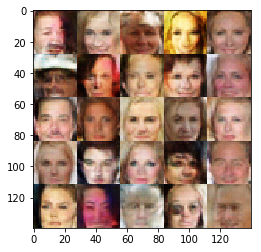

Epoch 1/2 Step 10410... Discriminator Loss: 1.3772... Generator Loss: 0.6890 ... Time spent=0.0639
Epoch 1/2 Step 10420... Discriminator Loss: 1.3870... Generator Loss: 0.7658 ... Time spent=0.0646
Epoch 1/2 Step 10430... Discriminator Loss: 1.3759... Generator Loss: 0.8066 ... Time spent=0.0644
Epoch 1/2 Step 10440... Discriminator Loss: 1.3722... Generator Loss: 0.7174 ... Time spent=0.0633
Epoch 1/2 Step 10450... Discriminator Loss: 1.2706... Generator Loss: 0.7827 ... Time spent=0.0639
Epoch 1/2 Step 10460... Discriminator Loss: 1.4504... Generator Loss: 0.7199 ... Time spent=0.0634
Epoch 1/2 Step 10470... Discriminator Loss: 1.2489... Generator Loss: 0.7863 ... Time spent=0.0639
Epoch 1/2 Step 10480... Discriminator Loss: 1.3708... Generator Loss: 0.7270 ... Time spent=0.0632
Epoch 1/2 Step 10490... Discriminator Loss: 1.4652... Generator Loss: 0.6563 ... Time spent=0.0633
Epoch 1/2 Step 10500... Discriminator Loss: 1.2275... Generator Loss: 0.8601 ... Time spent=0.0635
Epoch 1/2 

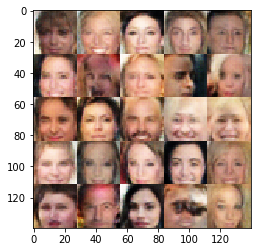

Epoch 1/2 Step 10610... Discriminator Loss: 1.2945... Generator Loss: 0.7726 ... Time spent=0.0645
Epoch 1/2 Step 10620... Discriminator Loss: 1.4029... Generator Loss: 0.6590 ... Time spent=0.0640
Epoch 1/2 Step 10630... Discriminator Loss: 1.4160... Generator Loss: 0.8553 ... Time spent=0.0654
Epoch 1/2 Step 10640... Discriminator Loss: 1.4290... Generator Loss: 0.6084 ... Time spent=0.0635
Epoch 1/2 Step 10650... Discriminator Loss: 1.4142... Generator Loss: 0.6945 ... Time spent=0.0631
Epoch 1/2 Step 10660... Discriminator Loss: 1.2791... Generator Loss: 0.7485 ... Time spent=0.0631
Epoch 1/2 Step 10670... Discriminator Loss: 1.3055... Generator Loss: 0.7756 ... Time spent=0.0634
Epoch 1/2 Step 10680... Discriminator Loss: 1.3603... Generator Loss: 0.7315 ... Time spent=0.0633
Epoch 1/2 Step 10690... Discriminator Loss: 1.3400... Generator Loss: 0.7060 ... Time spent=0.0633
Epoch 1/2 Step 10700... Discriminator Loss: 1.4275... Generator Loss: 0.5888 ... Time spent=0.0649
Epoch 1/2 

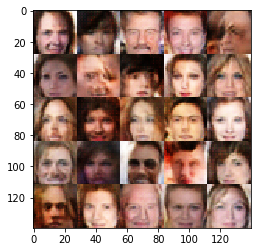

Epoch 1/2 Step 10810... Discriminator Loss: 1.3278... Generator Loss: 0.7022 ... Time spent=0.0653
Epoch 1/2 Step 10820... Discriminator Loss: 1.4265... Generator Loss: 0.6538 ... Time spent=0.0636
Epoch 1/2 Step 10830... Discriminator Loss: 1.3120... Generator Loss: 0.8155 ... Time spent=0.0638
Epoch 1/2 Step 10840... Discriminator Loss: 1.4023... Generator Loss: 0.6134 ... Time spent=0.0635
Epoch 1/2 Step 10850... Discriminator Loss: 1.3824... Generator Loss: 0.7432 ... Time spent=0.0641
Epoch 1/2 Step 10860... Discriminator Loss: 1.1509... Generator Loss: 0.8669 ... Time spent=0.0632
Epoch 1/2 Step 10870... Discriminator Loss: 1.5206... Generator Loss: 0.6365 ... Time spent=0.0650
Epoch 1/2 Step 10880... Discriminator Loss: 1.4280... Generator Loss: 0.6373 ... Time spent=0.0633
Epoch 1/2 Step 10890... Discriminator Loss: 1.3921... Generator Loss: 0.7506 ... Time spent=0.0645
Epoch 1/2 Step 10900... Discriminator Loss: 1.2901... Generator Loss: 0.7532 ... Time spent=0.0641
Epoch 1/2 

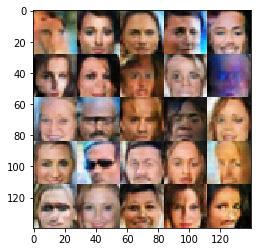

Epoch 1/2 Step 11010... Discriminator Loss: 1.4056... Generator Loss: 0.6995 ... Time spent=0.0632
Epoch 1/2 Step 11020... Discriminator Loss: 1.2080... Generator Loss: 0.8814 ... Time spent=0.0660
Epoch 1/2 Step 11030... Discriminator Loss: 1.4230... Generator Loss: 0.6820 ... Time spent=0.0633
Epoch 1/2 Step 11040... Discriminator Loss: 1.5352... Generator Loss: 0.5994 ... Time spent=0.0641
Epoch 1/2 Step 11050... Discriminator Loss: 1.3563... Generator Loss: 0.6892 ... Time spent=0.0645
Epoch 1/2 Step 11060... Discriminator Loss: 1.3175... Generator Loss: 0.7114 ... Time spent=0.0637
Epoch 1/2 Step 11070... Discriminator Loss: 1.4962... Generator Loss: 0.7066 ... Time spent=0.0634
Epoch 1/2 Step 11080... Discriminator Loss: 1.3066... Generator Loss: 0.8420 ... Time spent=0.0641
Epoch 1/2 Step 11090... Discriminator Loss: 1.3409... Generator Loss: 0.7430 ... Time spent=0.0630
Epoch 1/2 Step 11100... Discriminator Loss: 1.2975... Generator Loss: 0.7406 ... Time spent=0.0640
Epoch 1/2 

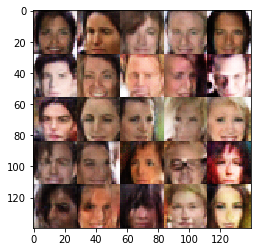

Epoch 1/2 Step 11210... Discriminator Loss: 1.4085... Generator Loss: 0.6893 ... Time spent=0.0635
Epoch 1/2 Step 11220... Discriminator Loss: 1.3035... Generator Loss: 0.7597 ... Time spent=0.0630
Epoch 1/2 Step 11230... Discriminator Loss: 1.4051... Generator Loss: 0.6355 ... Time spent=0.0637
Epoch 1/2 Step 11240... Discriminator Loss: 1.4090... Generator Loss: 0.7317 ... Time spent=0.0639
Epoch 1/2 Step 11250... Discriminator Loss: 1.2883... Generator Loss: 0.6895 ... Time spent=0.0634
Epoch 1/2 Step 11260... Discriminator Loss: 1.4212... Generator Loss: 0.6244 ... Time spent=0.0640
Epoch 1/2 Step 11270... Discriminator Loss: 1.3517... Generator Loss: 0.7559 ... Time spent=0.0638
Epoch 1/2 Step 11280... Discriminator Loss: 1.2899... Generator Loss: 0.7942 ... Time spent=0.0640
Epoch 1/2 Step 11290... Discriminator Loss: 1.3914... Generator Loss: 0.6984 ... Time spent=0.0637
Epoch 1/2 Step 11300... Discriminator Loss: 1.4330... Generator Loss: 0.6059 ... Time spent=0.0644
Epoch 1/2 

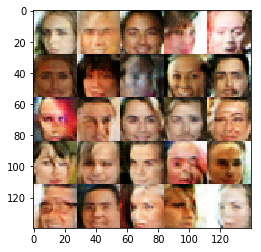

Epoch 1/2 Step 11410... Discriminator Loss: 1.3441... Generator Loss: 0.7333 ... Time spent=0.0627
Epoch 1/2 Step 11420... Discriminator Loss: 1.4005... Generator Loss: 0.6585 ... Time spent=0.0650
Epoch 1/2 Step 11430... Discriminator Loss: 1.5638... Generator Loss: 0.6183 ... Time spent=0.0633
Epoch 1/2 Step 11440... Discriminator Loss: 1.2552... Generator Loss: 0.8158 ... Time spent=0.0638
Epoch 1/2 Step 11450... Discriminator Loss: 1.2983... Generator Loss: 0.8053 ... Time spent=0.0649
Epoch 1/2 Step 11460... Discriminator Loss: 1.2755... Generator Loss: 0.8222 ... Time spent=0.0638
Epoch 1/2 Step 11470... Discriminator Loss: 1.3255... Generator Loss: 0.6881 ... Time spent=0.0637
Epoch 1/2 Step 11480... Discriminator Loss: 1.3638... Generator Loss: 0.7005 ... Time spent=0.0639
Epoch 1/2 Step 11490... Discriminator Loss: 1.4101... Generator Loss: 0.6291 ... Time spent=0.0630
Epoch 1/2 Step 11500... Discriminator Loss: 1.3468... Generator Loss: 0.7521 ... Time spent=0.0651
Epoch 1/2 

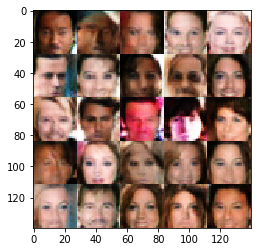

Epoch 1/2 Step 11610... Discriminator Loss: 1.2787... Generator Loss: 0.7826 ... Time spent=0.0643
Epoch 1/2 Step 11620... Discriminator Loss: 1.3357... Generator Loss: 0.7338 ... Time spent=0.0636
Epoch 1/2 Step 11630... Discriminator Loss: 1.1861... Generator Loss: 0.8480 ... Time spent=0.0634
Epoch 1/2 Step 11640... Discriminator Loss: 1.3629... Generator Loss: 0.7610 ... Time spent=0.0637
Epoch 1/2 Step 11650... Discriminator Loss: 1.3513... Generator Loss: 0.7070 ... Time spent=0.0642
Epoch 1/2 Step 11660... Discriminator Loss: 1.2474... Generator Loss: 0.7149 ... Time spent=0.0648
Epoch 1/2 Step 11670... Discriminator Loss: 1.2868... Generator Loss: 0.8049 ... Time spent=0.0625
Epoch 1/2 Step 11680... Discriminator Loss: 1.3894... Generator Loss: 0.6568 ... Time spent=0.0638
Epoch 1/2 Step 11690... Discriminator Loss: 1.4429... Generator Loss: 0.6879 ... Time spent=0.0633
Epoch 1/2 Step 11700... Discriminator Loss: 1.5800... Generator Loss: 0.5709 ... Time spent=0.0629
Epoch 1/2 

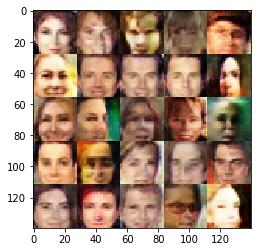

Epoch 1/2 Step 11810... Discriminator Loss: 1.3660... Generator Loss: 0.7438 ... Time spent=0.0638
Epoch 1/2 Step 11820... Discriminator Loss: 1.3590... Generator Loss: 0.7255 ... Time spent=0.0627
Epoch 1/2 Step 11830... Discriminator Loss: 1.2928... Generator Loss: 0.7414 ... Time spent=0.0632
Epoch 1/2 Step 11840... Discriminator Loss: 1.3456... Generator Loss: 0.7068 ... Time spent=0.0640
Epoch 1/2 Step 11850... Discriminator Loss: 1.3713... Generator Loss: 0.7519 ... Time spent=0.0640
Epoch 1/2 Step 11860... Discriminator Loss: 1.4984... Generator Loss: 0.7198 ... Time spent=0.0638
Epoch 1/2 Step 11870... Discriminator Loss: 1.3887... Generator Loss: 0.6961 ... Time spent=0.0630
Epoch 1/2 Step 11880... Discriminator Loss: 1.3625... Generator Loss: 0.7022 ... Time spent=0.0635
Epoch 1/2 Step 11890... Discriminator Loss: 1.2746... Generator Loss: 0.8335 ... Time spent=0.0635
Epoch 1/2 Step 11900... Discriminator Loss: 1.3443... Generator Loss: 0.7535 ... Time spent=0.0637
Epoch 1/2 

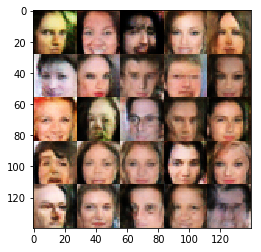

Epoch 1/2 Step 12010... Discriminator Loss: 1.5115... Generator Loss: 0.5641 ... Time spent=0.0639
Epoch 1/2 Step 12020... Discriminator Loss: 1.2243... Generator Loss: 0.8149 ... Time spent=0.0643
Epoch 1/2 Step 12030... Discriminator Loss: 1.4435... Generator Loss: 0.6284 ... Time spent=0.0640
Epoch 1/2 Step 12040... Discriminator Loss: 1.3901... Generator Loss: 0.6887 ... Time spent=0.0642
Epoch 1/2 Step 12050... Discriminator Loss: 1.2766... Generator Loss: 0.8492 ... Time spent=0.0655
Epoch 1/2 Step 12060... Discriminator Loss: 1.3865... Generator Loss: 0.6364 ... Time spent=0.0636
Epoch 1/2 Step 12070... Discriminator Loss: 1.5345... Generator Loss: 0.5857 ... Time spent=0.0635
Epoch 1/2 Step 12080... Discriminator Loss: 1.4607... Generator Loss: 0.6802 ... Time spent=0.0641
Epoch 1/2 Step 12090... Discriminator Loss: 1.2116... Generator Loss: 0.7939 ... Time spent=0.0637
Epoch 1/2 Step 12100... Discriminator Loss: 1.2597... Generator Loss: 0.7679 ... Time spent=0.0651
Epoch 1/2 

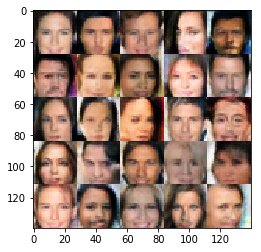

Epoch 1/2 Step 12210... Discriminator Loss: 1.3214... Generator Loss: 0.8396 ... Time spent=0.0641
Epoch 1/2 Step 12220... Discriminator Loss: 1.4617... Generator Loss: 0.6508 ... Time spent=0.0641
Epoch 1/2 Step 12230... Discriminator Loss: 1.4214... Generator Loss: 0.7178 ... Time spent=0.0639
Epoch 1/2 Step 12240... Discriminator Loss: 1.4721... Generator Loss: 0.6292 ... Time spent=0.0636
Epoch 1/2 Step 12250... Discriminator Loss: 1.3996... Generator Loss: 0.6026 ... Time spent=0.0632
Epoch 1/2 Step 12260... Discriminator Loss: 1.4620... Generator Loss: 0.6096 ... Time spent=0.0635
Epoch 1/2 Step 12270... Discriminator Loss: 1.3048... Generator Loss: 0.7535 ... Time spent=0.0635
Epoch 1/2 Step 12280... Discriminator Loss: 1.2959... Generator Loss: 0.8007 ... Time spent=0.0630
Epoch 1/2 Step 12290... Discriminator Loss: 1.3664... Generator Loss: 0.7199 ... Time spent=0.0644
Epoch 1/2 Step 12300... Discriminator Loss: 1.4837... Generator Loss: 0.6867 ... Time spent=0.0640
Epoch 1/2 

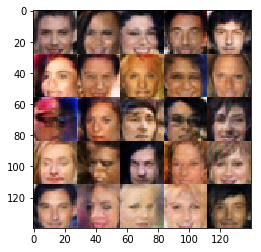

Epoch 1/2 Step 12410... Discriminator Loss: 1.2683... Generator Loss: 0.7930 ... Time spent=0.0632
Epoch 1/2 Step 12420... Discriminator Loss: 1.3674... Generator Loss: 0.7142 ... Time spent=0.0638
Epoch 1/2 Step 12430... Discriminator Loss: 1.4657... Generator Loss: 0.6253 ... Time spent=0.0636
Epoch 1/2 Step 12440... Discriminator Loss: 1.3239... Generator Loss: 0.7794 ... Time spent=0.0662
Epoch 1/2 Step 12450... Discriminator Loss: 1.3232... Generator Loss: 0.7120 ... Time spent=0.0637
Epoch 1/2 Step 12460... Discriminator Loss: 1.4428... Generator Loss: 0.6842 ... Time spent=0.0648
Epoch 1/2 Step 12470... Discriminator Loss: 1.3518... Generator Loss: 0.8408 ... Time spent=0.0639
Epoch 1/2 Step 12480... Discriminator Loss: 1.3878... Generator Loss: 0.6808 ... Time spent=0.0653
Epoch 1/2 Step 12490... Discriminator Loss: 1.5198... Generator Loss: 0.6764 ... Time spent=0.0633
Epoch 1/2 Step 12500... Discriminator Loss: 1.3810... Generator Loss: 0.6152 ... Time spent=0.0635
Epoch 1/2 

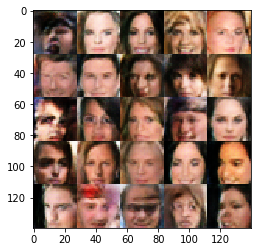

Epoch 1/2 Step 12610... Discriminator Loss: 1.2653... Generator Loss: 0.7947 ... Time spent=0.0647
Epoch 1/2 Step 12620... Discriminator Loss: 1.4289... Generator Loss: 0.6349 ... Time spent=0.0634
Epoch 1/2 Step 12630... Discriminator Loss: 1.2877... Generator Loss: 0.7940 ... Time spent=0.0632
Epoch 1/2 Step 12640... Discriminator Loss: 1.3909... Generator Loss: 0.7596 ... Time spent=0.0635
Epoch 1/2 Step 12650... Discriminator Loss: 1.3466... Generator Loss: 0.7333 ... Time spent=0.0679
Epoch 1/2 Step 12660... Discriminator Loss: 1.3339... Generator Loss: 0.7509 ... Time spent=0.0634
Epoch 2/2 Step 12670... Discriminator Loss: 1.2864... Generator Loss: 0.7742 ... Time spent=0.0639
Epoch 2/2 Step 12680... Discriminator Loss: 1.2756... Generator Loss: 0.7465 ... Time spent=0.0638
Epoch 2/2 Step 12690... Discriminator Loss: 1.2852... Generator Loss: 0.7461 ... Time spent=0.0646
Epoch 2/2 Step 12700... Discriminator Loss: 1.3445... Generator Loss: 0.7137 ... Time spent=0.0637
Epoch 2/2 

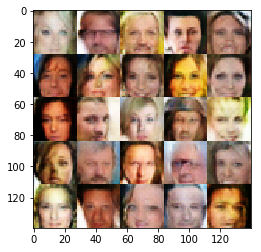

Epoch 2/2 Step 12810... Discriminator Loss: 1.3839... Generator Loss: 0.7194 ... Time spent=0.0654
Epoch 2/2 Step 12820... Discriminator Loss: 1.4640... Generator Loss: 0.7073 ... Time spent=0.0634
Epoch 2/2 Step 12830... Discriminator Loss: 1.3402... Generator Loss: 0.7173 ... Time spent=0.0645
Epoch 2/2 Step 12840... Discriminator Loss: 1.4584... Generator Loss: 0.6493 ... Time spent=0.0632
Epoch 2/2 Step 12850... Discriminator Loss: 1.4141... Generator Loss: 0.6380 ... Time spent=0.0636
Epoch 2/2 Step 12860... Discriminator Loss: 1.3140... Generator Loss: 0.7230 ... Time spent=0.0641
Epoch 2/2 Step 12870... Discriminator Loss: 1.4044... Generator Loss: 0.6752 ... Time spent=0.0632
Epoch 2/2 Step 12880... Discriminator Loss: 1.3021... Generator Loss: 0.7320 ... Time spent=0.0645
Epoch 2/2 Step 12890... Discriminator Loss: 1.2698... Generator Loss: 0.8191 ... Time spent=0.0639
Epoch 2/2 Step 12900... Discriminator Loss: 1.4759... Generator Loss: 0.6215 ... Time spent=0.0643
Epoch 2/2 

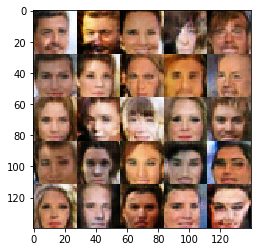

Epoch 2/2 Step 13010... Discriminator Loss: 1.2825... Generator Loss: 0.7622 ... Time spent=0.0631
Epoch 2/2 Step 13020... Discriminator Loss: 1.4239... Generator Loss: 0.7684 ... Time spent=0.0635
Epoch 2/2 Step 13030... Discriminator Loss: 1.5117... Generator Loss: 0.6479 ... Time spent=0.0634
Epoch 2/2 Step 13040... Discriminator Loss: 1.2798... Generator Loss: 0.7604 ... Time spent=0.0635
Epoch 2/2 Step 13050... Discriminator Loss: 1.3849... Generator Loss: 0.6897 ... Time spent=0.0635
Epoch 2/2 Step 13060... Discriminator Loss: 1.2945... Generator Loss: 0.7690 ... Time spent=0.0637
Epoch 2/2 Step 13070... Discriminator Loss: 1.2343... Generator Loss: 0.9262 ... Time spent=0.0633
Epoch 2/2 Step 13080... Discriminator Loss: 1.5893... Generator Loss: 0.5980 ... Time spent=0.0638
Epoch 2/2 Step 13090... Discriminator Loss: 1.3283... Generator Loss: 0.7520 ... Time spent=0.0629
Epoch 2/2 Step 13100... Discriminator Loss: 1.4771... Generator Loss: 0.7825 ... Time spent=0.0652
Epoch 2/2 

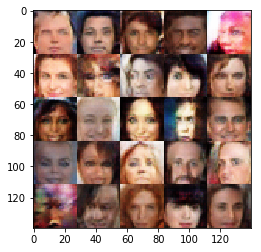

Epoch 2/2 Step 13210... Discriminator Loss: 1.4715... Generator Loss: 0.7173 ... Time spent=0.0638
Epoch 2/2 Step 13220... Discriminator Loss: 1.5010... Generator Loss: 0.6468 ... Time spent=0.0640
Epoch 2/2 Step 13230... Discriminator Loss: 1.2726... Generator Loss: 0.8474 ... Time spent=0.0632
Epoch 2/2 Step 13240... Discriminator Loss: 1.5013... Generator Loss: 0.5725 ... Time spent=0.0631
Epoch 2/2 Step 13250... Discriminator Loss: 1.4658... Generator Loss: 0.6457 ... Time spent=0.0633
Epoch 2/2 Step 13260... Discriminator Loss: 1.3510... Generator Loss: 0.7786 ... Time spent=0.0651
Epoch 2/2 Step 13270... Discriminator Loss: 1.3810... Generator Loss: 0.6765 ... Time spent=0.0636
Epoch 2/2 Step 13280... Discriminator Loss: 1.3966... Generator Loss: 0.6554 ... Time spent=0.0634
Epoch 2/2 Step 13290... Discriminator Loss: 1.2836... Generator Loss: 0.7355 ... Time spent=0.0636
Epoch 2/2 Step 13300... Discriminator Loss: 1.3092... Generator Loss: 0.7563 ... Time spent=0.0641
Epoch 2/2 

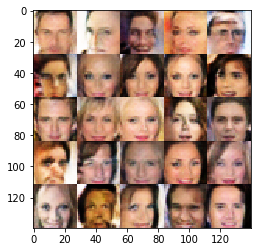

Epoch 2/2 Step 13410... Discriminator Loss: 1.2685... Generator Loss: 0.7934 ... Time spent=0.0658
Epoch 2/2 Step 13420... Discriminator Loss: 1.4764... Generator Loss: 0.7472 ... Time spent=0.0630
Epoch 2/2 Step 13430... Discriminator Loss: 1.3143... Generator Loss: 0.7762 ... Time spent=0.0637
Epoch 2/2 Step 13440... Discriminator Loss: 1.2057... Generator Loss: 0.8517 ... Time spent=0.0641
Epoch 2/2 Step 13450... Discriminator Loss: 1.2370... Generator Loss: 0.8805 ... Time spent=0.0636
Epoch 2/2 Step 13460... Discriminator Loss: 1.2208... Generator Loss: 0.8450 ... Time spent=0.0636
Epoch 2/2 Step 13470... Discriminator Loss: 1.4028... Generator Loss: 0.7051 ... Time spent=0.0639
Epoch 2/2 Step 13480... Discriminator Loss: 1.5940... Generator Loss: 0.5112 ... Time spent=0.0640
Epoch 2/2 Step 13490... Discriminator Loss: 1.3164... Generator Loss: 0.7537 ... Time spent=0.0645
Epoch 2/2 Step 13500... Discriminator Loss: 1.4600... Generator Loss: 0.6620 ... Time spent=0.0644
Epoch 2/2 

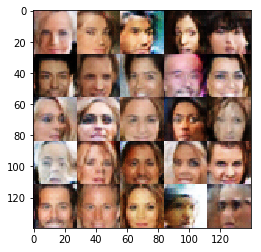

Epoch 2/2 Step 13610... Discriminator Loss: 1.2045... Generator Loss: 0.9165 ... Time spent=0.0643
Epoch 2/2 Step 13620... Discriminator Loss: 1.4566... Generator Loss: 0.6649 ... Time spent=0.0672
Epoch 2/2 Step 13630... Discriminator Loss: 1.2571... Generator Loss: 0.7999 ... Time spent=0.0636
Epoch 2/2 Step 13640... Discriminator Loss: 1.3091... Generator Loss: 0.7469 ... Time spent=0.0635
Epoch 2/2 Step 13650... Discriminator Loss: 1.4495... Generator Loss: 0.6189 ... Time spent=0.0643
Epoch 2/2 Step 13660... Discriminator Loss: 1.3831... Generator Loss: 0.7450 ... Time spent=0.0637
Epoch 2/2 Step 13670... Discriminator Loss: 1.2802... Generator Loss: 0.8126 ... Time spent=0.0640
Epoch 2/2 Step 13680... Discriminator Loss: 1.3709... Generator Loss: 0.7072 ... Time spent=0.0646
Epoch 2/2 Step 13690... Discriminator Loss: 1.3409... Generator Loss: 0.7604 ... Time spent=0.0641
Epoch 2/2 Step 13700... Discriminator Loss: 1.2653... Generator Loss: 0.7732 ... Time spent=0.0656
Epoch 2/2 

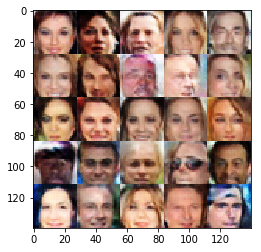

Epoch 2/2 Step 13810... Discriminator Loss: 1.3213... Generator Loss: 0.6985 ... Time spent=0.0642
Epoch 2/2 Step 13820... Discriminator Loss: 1.2879... Generator Loss: 0.7131 ... Time spent=0.0647
Epoch 2/2 Step 13830... Discriminator Loss: 1.3111... Generator Loss: 0.7428 ... Time spent=0.0715
Epoch 2/2 Step 13840... Discriminator Loss: 1.3836... Generator Loss: 0.6307 ... Time spent=0.0633
Epoch 2/2 Step 13850... Discriminator Loss: 1.1990... Generator Loss: 0.8418 ... Time spent=0.0636
Epoch 2/2 Step 13860... Discriminator Loss: 1.3060... Generator Loss: 0.7441 ... Time spent=0.0640
Epoch 2/2 Step 13870... Discriminator Loss: 1.2412... Generator Loss: 0.8861 ... Time spent=0.0637
Epoch 2/2 Step 13880... Discriminator Loss: 1.1898... Generator Loss: 0.8872 ... Time spent=0.0637
Epoch 2/2 Step 13890... Discriminator Loss: 1.4072... Generator Loss: 0.7209 ... Time spent=0.0644
Epoch 2/2 Step 13900... Discriminator Loss: 1.2310... Generator Loss: 0.8078 ... Time spent=0.0630
Epoch 2/2 

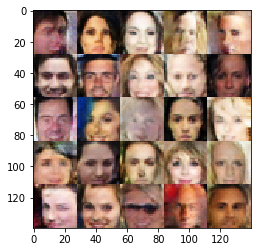

Epoch 2/2 Step 14010... Discriminator Loss: 1.2247... Generator Loss: 0.8790 ... Time spent=0.0651
Epoch 2/2 Step 14020... Discriminator Loss: 1.4127... Generator Loss: 0.8061 ... Time spent=0.0636
Epoch 2/2 Step 14030... Discriminator Loss: 1.3036... Generator Loss: 0.7545 ... Time spent=0.0643
Epoch 2/2 Step 14040... Discriminator Loss: 1.2815... Generator Loss: 0.7338 ... Time spent=0.0631
Epoch 2/2 Step 14050... Discriminator Loss: 1.4189... Generator Loss: 0.6174 ... Time spent=0.0634
Epoch 2/2 Step 14060... Discriminator Loss: 1.2906... Generator Loss: 0.8905 ... Time spent=0.0638
Epoch 2/2 Step 14070... Discriminator Loss: 1.3264... Generator Loss: 0.7483 ... Time spent=0.0636
Epoch 2/2 Step 14080... Discriminator Loss: 1.3431... Generator Loss: 0.7580 ... Time spent=0.0671
Epoch 2/2 Step 14090... Discriminator Loss: 1.3993... Generator Loss: 0.6682 ... Time spent=0.0633
Epoch 2/2 Step 14100... Discriminator Loss: 1.3022... Generator Loss: 0.7726 ... Time spent=0.0635
Epoch 2/2 

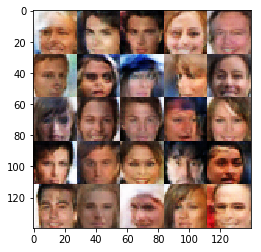

Epoch 2/2 Step 14210... Discriminator Loss: 1.4368... Generator Loss: 0.6939 ... Time spent=0.0636
Epoch 2/2 Step 14220... Discriminator Loss: 1.3602... Generator Loss: 0.7633 ... Time spent=0.0638
Epoch 2/2 Step 14230... Discriminator Loss: 1.2941... Generator Loss: 0.7962 ... Time spent=0.0643
Epoch 2/2 Step 14240... Discriminator Loss: 1.3926... Generator Loss: 0.8169 ... Time spent=0.0636
Epoch 2/2 Step 14250... Discriminator Loss: 1.2160... Generator Loss: 0.7948 ... Time spent=0.0649
Epoch 2/2 Step 14260... Discriminator Loss: 1.3370... Generator Loss: 0.6517 ... Time spent=0.0642
Epoch 2/2 Step 14270... Discriminator Loss: 1.3525... Generator Loss: 0.7283 ... Time spent=0.0638
Epoch 2/2 Step 14280... Discriminator Loss: 1.2596... Generator Loss: 0.7662 ... Time spent=0.0637
Epoch 2/2 Step 14290... Discriminator Loss: 1.2639... Generator Loss: 0.7513 ... Time spent=0.0640
Epoch 2/2 Step 14300... Discriminator Loss: 1.3053... Generator Loss: 0.7093 ... Time spent=0.0643
Epoch 2/2 

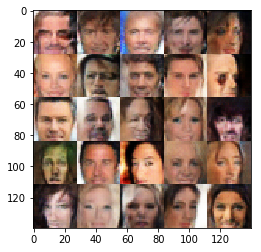

Epoch 2/2 Step 14410... Discriminator Loss: 1.4703... Generator Loss: 0.6457 ... Time spent=0.0628
Epoch 2/2 Step 14420... Discriminator Loss: 1.4940... Generator Loss: 0.6600 ... Time spent=0.0639
Epoch 2/2 Step 14430... Discriminator Loss: 1.4561... Generator Loss: 0.5989 ... Time spent=0.0644
Epoch 2/2 Step 14440... Discriminator Loss: 1.2880... Generator Loss: 0.7336 ... Time spent=0.0642
Epoch 2/2 Step 14450... Discriminator Loss: 1.5057... Generator Loss: 0.6546 ... Time spent=0.0653
Epoch 2/2 Step 14460... Discriminator Loss: 1.5207... Generator Loss: 0.5845 ... Time spent=0.0629
Epoch 2/2 Step 14470... Discriminator Loss: 1.4358... Generator Loss: 0.6761 ... Time spent=0.0635
Epoch 2/2 Step 14480... Discriminator Loss: 1.4455... Generator Loss: 0.6918 ... Time spent=0.0633
Epoch 2/2 Step 14490... Discriminator Loss: 1.3488... Generator Loss: 0.7102 ... Time spent=0.0648
Epoch 2/2 Step 14500... Discriminator Loss: 1.3267... Generator Loss: 0.7413 ... Time spent=0.0633
Epoch 2/2 

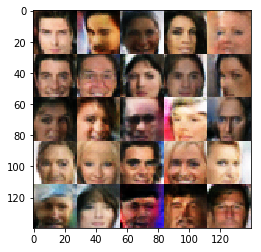

Epoch 2/2 Step 14610... Discriminator Loss: 1.3036... Generator Loss: 0.7330 ... Time spent=0.0635
Epoch 2/2 Step 14620... Discriminator Loss: 1.4245... Generator Loss: 0.6428 ... Time spent=0.0631
Epoch 2/2 Step 14630... Discriminator Loss: 1.3457... Generator Loss: 0.7342 ... Time spent=0.0640
Epoch 2/2 Step 14640... Discriminator Loss: 1.3361... Generator Loss: 0.6934 ... Time spent=0.0635
Epoch 2/2 Step 14650... Discriminator Loss: 1.2913... Generator Loss: 0.7847 ... Time spent=0.0632
Epoch 2/2 Step 14660... Discriminator Loss: 1.5828... Generator Loss: 0.6019 ... Time spent=0.0637
Epoch 2/2 Step 14670... Discriminator Loss: 1.4051... Generator Loss: 0.6676 ... Time spent=0.0638
Epoch 2/2 Step 14680... Discriminator Loss: 1.2937... Generator Loss: 0.7846 ... Time spent=0.0633
Epoch 2/2 Step 14690... Discriminator Loss: 1.3878... Generator Loss: 0.6944 ... Time spent=0.0646
Epoch 2/2 Step 14700... Discriminator Loss: 1.2528... Generator Loss: 0.8498 ... Time spent=0.0647
Epoch 2/2 

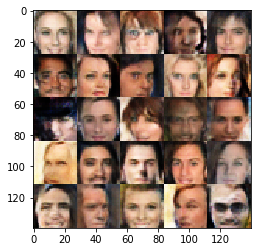

Epoch 2/2 Step 14810... Discriminator Loss: 1.4350... Generator Loss: 0.5853 ... Time spent=0.0640
Epoch 2/2 Step 14820... Discriminator Loss: 1.2747... Generator Loss: 0.7577 ... Time spent=0.0638
Epoch 2/2 Step 14830... Discriminator Loss: 1.4224... Generator Loss: 0.6724 ... Time spent=0.0636
Epoch 2/2 Step 14840... Discriminator Loss: 1.3744... Generator Loss: 0.8194 ... Time spent=0.0643
Epoch 2/2 Step 14850... Discriminator Loss: 1.3002... Generator Loss: 0.7459 ... Time spent=0.0642
Epoch 2/2 Step 14860... Discriminator Loss: 1.2041... Generator Loss: 0.9006 ... Time spent=0.0634
Epoch 2/2 Step 14870... Discriminator Loss: 1.4292... Generator Loss: 0.7069 ... Time spent=0.0636
Epoch 2/2 Step 14880... Discriminator Loss: 1.3665... Generator Loss: 0.7763 ... Time spent=0.0642
Epoch 2/2 Step 14890... Discriminator Loss: 1.3274... Generator Loss: 0.7891 ... Time spent=0.0648
Epoch 2/2 Step 14900... Discriminator Loss: 1.1922... Generator Loss: 0.8400 ... Time spent=0.0653
Epoch 2/2 

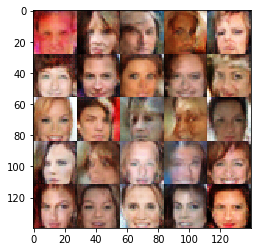

Epoch 2/2 Step 15010... Discriminator Loss: 1.3567... Generator Loss: 0.7344 ... Time spent=0.0645
Epoch 2/2 Step 15020... Discriminator Loss: 1.3246... Generator Loss: 0.7438 ... Time spent=0.0641
Epoch 2/2 Step 15030... Discriminator Loss: 1.2044... Generator Loss: 0.8839 ... Time spent=0.0644
Epoch 2/2 Step 15040... Discriminator Loss: 1.4740... Generator Loss: 0.7499 ... Time spent=0.0638
Epoch 2/2 Step 15050... Discriminator Loss: 1.3034... Generator Loss: 0.8207 ... Time spent=0.0649
Epoch 2/2 Step 15060... Discriminator Loss: 1.2400... Generator Loss: 0.8594 ... Time spent=0.0647
Epoch 2/2 Step 15070... Discriminator Loss: 1.3412... Generator Loss: 0.8214 ... Time spent=0.0656
Epoch 2/2 Step 15080... Discriminator Loss: 1.4430... Generator Loss: 0.6516 ... Time spent=0.0637
Epoch 2/2 Step 15090... Discriminator Loss: 1.4669... Generator Loss: 0.6518 ... Time spent=0.0645
Epoch 2/2 Step 15100... Discriminator Loss: 1.2717... Generator Loss: 0.8143 ... Time spent=0.0639
Epoch 2/2 

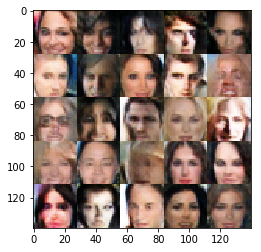

Epoch 2/2 Step 15210... Discriminator Loss: 1.4343... Generator Loss: 0.7353 ... Time spent=0.0632
Epoch 2/2 Step 15220... Discriminator Loss: 1.3761... Generator Loss: 0.7460 ... Time spent=0.0635
Epoch 2/2 Step 15230... Discriminator Loss: 1.5157... Generator Loss: 0.6418 ... Time spent=0.0647
Epoch 2/2 Step 15240... Discriminator Loss: 1.3742... Generator Loss: 0.6734 ... Time spent=0.0651
Epoch 2/2 Step 15250... Discriminator Loss: 1.3092... Generator Loss: 0.7726 ... Time spent=0.0643
Epoch 2/2 Step 15260... Discriminator Loss: 1.2562... Generator Loss: 0.7891 ... Time spent=0.0636
Epoch 2/2 Step 15270... Discriminator Loss: 1.4170... Generator Loss: 0.6769 ... Time spent=0.0635
Epoch 2/2 Step 15280... Discriminator Loss: 1.4217... Generator Loss: 0.5645 ... Time spent=0.0642
Epoch 2/2 Step 15290... Discriminator Loss: 1.4977... Generator Loss: 0.5879 ... Time spent=0.0636
Epoch 2/2 Step 15300... Discriminator Loss: 1.2923... Generator Loss: 0.7440 ... Time spent=0.0643
Epoch 2/2 

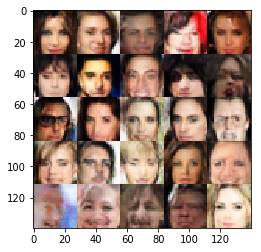

Epoch 2/2 Step 15410... Discriminator Loss: 1.2312... Generator Loss: 0.8764 ... Time spent=0.0642
Epoch 2/2 Step 15420... Discriminator Loss: 1.2638... Generator Loss: 0.8416 ... Time spent=0.0632
Epoch 2/2 Step 15430... Discriminator Loss: 1.3225... Generator Loss: 0.7861 ... Time spent=0.0645
Epoch 2/2 Step 15440... Discriminator Loss: 1.3894... Generator Loss: 0.7768 ... Time spent=0.0639
Epoch 2/2 Step 15450... Discriminator Loss: 1.3577... Generator Loss: 0.7060 ... Time spent=0.0642
Epoch 2/2 Step 15460... Discriminator Loss: 1.3105... Generator Loss: 0.6989 ... Time spent=0.0641
Epoch 2/2 Step 15470... Discriminator Loss: 1.2390... Generator Loss: 0.8062 ... Time spent=0.0664
Epoch 2/2 Step 15480... Discriminator Loss: 1.4279... Generator Loss: 0.7531 ... Time spent=0.0638
Epoch 2/2 Step 15490... Discriminator Loss: 1.2461... Generator Loss: 0.7405 ... Time spent=0.0645
Epoch 2/2 Step 15500... Discriminator Loss: 1.3542... Generator Loss: 0.7182 ... Time spent=0.0652
Epoch 2/2 

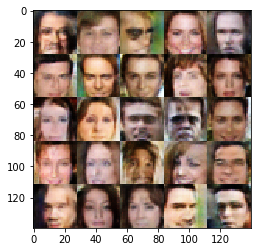

Epoch 2/2 Step 15610... Discriminator Loss: 1.3653... Generator Loss: 0.6959 ... Time spent=0.0639
Epoch 2/2 Step 15620... Discriminator Loss: 1.4039... Generator Loss: 0.6167 ... Time spent=0.0643
Epoch 2/2 Step 15630... Discriminator Loss: 1.3477... Generator Loss: 0.6787 ... Time spent=0.0634
Epoch 2/2 Step 15640... Discriminator Loss: 1.3475... Generator Loss: 0.8114 ... Time spent=0.0651
Epoch 2/2 Step 15650... Discriminator Loss: 1.4233... Generator Loss: 0.7057 ... Time spent=0.0634
Epoch 2/2 Step 15660... Discriminator Loss: 1.3918... Generator Loss: 0.6693 ... Time spent=0.0634
Epoch 2/2 Step 15670... Discriminator Loss: 1.2607... Generator Loss: 0.7991 ... Time spent=0.0638
Epoch 2/2 Step 15680... Discriminator Loss: 1.2498... Generator Loss: 0.8179 ... Time spent=0.0649
Epoch 2/2 Step 15690... Discriminator Loss: 1.3546... Generator Loss: 0.7300 ... Time spent=0.0641
Epoch 2/2 Step 15700... Discriminator Loss: 1.3016... Generator Loss: 0.6742 ... Time spent=0.0637
Epoch 2/2 

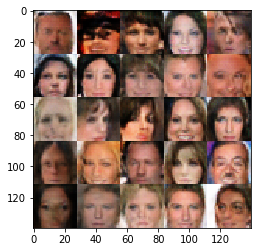

Epoch 2/2 Step 15810... Discriminator Loss: 1.2998... Generator Loss: 0.7230 ... Time spent=0.0645
Epoch 2/2 Step 15820... Discriminator Loss: 1.3212... Generator Loss: 0.7730 ... Time spent=0.0636
Epoch 2/2 Step 15830... Discriminator Loss: 1.4359... Generator Loss: 0.7307 ... Time spent=0.0635
Epoch 2/2 Step 15840... Discriminator Loss: 1.2447... Generator Loss: 0.8385 ... Time spent=0.0638
Epoch 2/2 Step 15850... Discriminator Loss: 1.3249... Generator Loss: 0.6632 ... Time spent=0.0631
Epoch 2/2 Step 15860... Discriminator Loss: 1.3382... Generator Loss: 0.7147 ... Time spent=0.0645
Epoch 2/2 Step 15870... Discriminator Loss: 1.2356... Generator Loss: 0.8158 ... Time spent=0.0654
Epoch 2/2 Step 15880... Discriminator Loss: 1.2819... Generator Loss: 0.7024 ... Time spent=0.0639
Epoch 2/2 Step 15890... Discriminator Loss: 1.4590... Generator Loss: 0.7708 ... Time spent=0.0639
Epoch 2/2 Step 15900... Discriminator Loss: 1.2176... Generator Loss: 0.8550 ... Time spent=0.0628
Epoch 2/2 

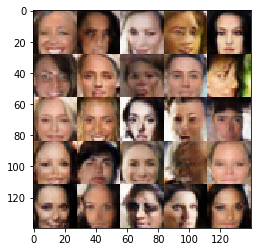

Epoch 2/2 Step 16010... Discriminator Loss: 1.3732... Generator Loss: 0.7814 ... Time spent=0.0642
Epoch 2/2 Step 16020... Discriminator Loss: 1.3848... Generator Loss: 0.8111 ... Time spent=0.0634
Epoch 2/2 Step 16030... Discriminator Loss: 1.3899... Generator Loss: 0.6694 ... Time spent=0.0641
Epoch 2/2 Step 16040... Discriminator Loss: 1.4451... Generator Loss: 0.7187 ... Time spent=0.0638
Epoch 2/2 Step 16050... Discriminator Loss: 1.2618... Generator Loss: 0.7798 ... Time spent=0.0645
Epoch 2/2 Step 16060... Discriminator Loss: 1.2564... Generator Loss: 0.7610 ... Time spent=0.0634
Epoch 2/2 Step 16070... Discriminator Loss: 1.6167... Generator Loss: 0.5599 ... Time spent=0.0640
Epoch 2/2 Step 16080... Discriminator Loss: 1.3389... Generator Loss: 0.7467 ... Time spent=0.0637
Epoch 2/2 Step 16090... Discriminator Loss: 1.3563... Generator Loss: 0.6970 ... Time spent=0.0634
Epoch 2/2 Step 16100... Discriminator Loss: 1.3633... Generator Loss: 0.6606 ... Time spent=0.0643
Epoch 2/2 

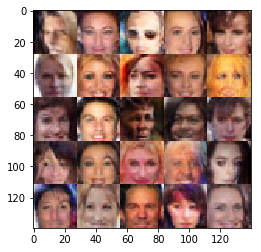

Epoch 2/2 Step 16210... Discriminator Loss: 1.3844... Generator Loss: 0.7249 ... Time spent=0.0648
Epoch 2/2 Step 16220... Discriminator Loss: 1.4818... Generator Loss: 0.6095 ... Time spent=0.0643
Epoch 2/2 Step 16230... Discriminator Loss: 1.3658... Generator Loss: 0.6799 ... Time spent=0.0634
Epoch 2/2 Step 16240... Discriminator Loss: 1.3729... Generator Loss: 0.7285 ... Time spent=0.0632
Epoch 2/2 Step 16250... Discriminator Loss: 1.4767... Generator Loss: 0.6921 ... Time spent=0.0633
Epoch 2/2 Step 16260... Discriminator Loss: 1.4106... Generator Loss: 0.6762 ... Time spent=0.0638
Epoch 2/2 Step 16270... Discriminator Loss: 1.3525... Generator Loss: 0.6802 ... Time spent=0.0663
Epoch 2/2 Step 16280... Discriminator Loss: 1.2362... Generator Loss: 0.7937 ... Time spent=0.0647
Epoch 2/2 Step 16290... Discriminator Loss: 1.3126... Generator Loss: 0.7279 ... Time spent=0.0651
Epoch 2/2 Step 16300... Discriminator Loss: 1.2585... Generator Loss: 0.8346 ... Time spent=0.0642
Epoch 2/2 

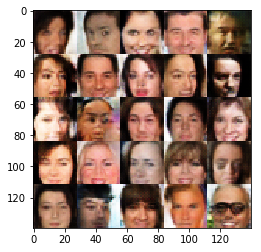

Epoch 2/2 Step 16410... Discriminator Loss: 1.3155... Generator Loss: 0.7574 ... Time spent=0.0639
Epoch 2/2 Step 16420... Discriminator Loss: 1.4007... Generator Loss: 0.6941 ... Time spent=0.0630
Epoch 2/2 Step 16430... Discriminator Loss: 1.4383... Generator Loss: 0.7014 ... Time spent=0.0663
Epoch 2/2 Step 16440... Discriminator Loss: 1.4971... Generator Loss: 0.6106 ... Time spent=0.0656
Epoch 2/2 Step 16450... Discriminator Loss: 1.5924... Generator Loss: 0.5532 ... Time spent=0.0633
Epoch 2/2 Step 16460... Discriminator Loss: 1.4207... Generator Loss: 0.6607 ... Time spent=0.0639
Epoch 2/2 Step 16470... Discriminator Loss: 1.5966... Generator Loss: 0.4632 ... Time spent=0.0633
Epoch 2/2 Step 16480... Discriminator Loss: 1.4489... Generator Loss: 0.6884 ... Time spent=0.0628
Epoch 2/2 Step 16490... Discriminator Loss: 1.1944... Generator Loss: 0.8854 ... Time spent=0.0635
Epoch 2/2 Step 16500... Discriminator Loss: 1.2939... Generator Loss: 0.7829 ... Time spent=0.0642
Epoch 2/2 

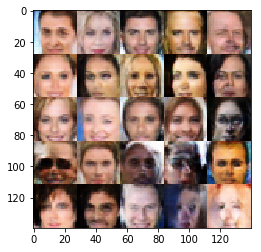

Epoch 2/2 Step 16610... Discriminator Loss: 1.2887... Generator Loss: 0.7565 ... Time spent=0.0644
Epoch 2/2 Step 16620... Discriminator Loss: 1.2085... Generator Loss: 0.8042 ... Time spent=0.0642
Epoch 2/2 Step 16630... Discriminator Loss: 1.2714... Generator Loss: 0.7234 ... Time spent=0.0639
Epoch 2/2 Step 16640... Discriminator Loss: 1.2914... Generator Loss: 0.7960 ... Time spent=0.0635
Epoch 2/2 Step 16650... Discriminator Loss: 1.3749... Generator Loss: 0.7105 ... Time spent=0.0641
Epoch 2/2 Step 16660... Discriminator Loss: 1.2731... Generator Loss: 0.7770 ... Time spent=0.0634
Epoch 2/2 Step 16670... Discriminator Loss: 1.3854... Generator Loss: 0.8198 ... Time spent=0.0634
Epoch 2/2 Step 16680... Discriminator Loss: 1.3844... Generator Loss: 0.6888 ... Time spent=0.0646
Epoch 2/2 Step 16690... Discriminator Loss: 1.4008... Generator Loss: 0.5959 ... Time spent=0.0643
Epoch 2/2 Step 16700... Discriminator Loss: 1.3170... Generator Loss: 0.7250 ... Time spent=0.0644
Epoch 2/2 

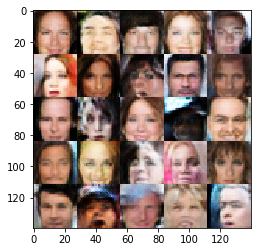

Epoch 2/2 Step 16810... Discriminator Loss: 1.4187... Generator Loss: 0.6579 ... Time spent=0.0635
Epoch 2/2 Step 16820... Discriminator Loss: 1.3397... Generator Loss: 0.7895 ... Time spent=0.0641
Epoch 2/2 Step 16830... Discriminator Loss: 1.3370... Generator Loss: 0.7011 ... Time spent=0.0695
Epoch 2/2 Step 16840... Discriminator Loss: 1.2982... Generator Loss: 0.7823 ... Time spent=0.0634
Epoch 2/2 Step 16850... Discriminator Loss: 1.3978... Generator Loss: 0.6932 ... Time spent=0.0635
Epoch 2/2 Step 16860... Discriminator Loss: 1.4406... Generator Loss: 0.7263 ... Time spent=0.0643
Epoch 2/2 Step 16870... Discriminator Loss: 1.4220... Generator Loss: 0.6817 ... Time spent=0.0647
Epoch 2/2 Step 16880... Discriminator Loss: 1.3146... Generator Loss: 0.6800 ... Time spent=0.0639
Epoch 2/2 Step 16890... Discriminator Loss: 1.3167... Generator Loss: 0.8205 ... Time spent=0.0631
Epoch 2/2 Step 16900... Discriminator Loss: 1.5127... Generator Loss: 0.7587 ... Time spent=0.0650
Epoch 2/2 

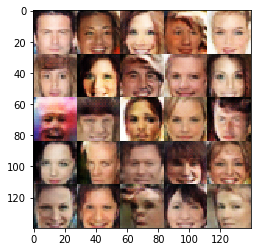

Epoch 2/2 Step 17010... Discriminator Loss: 1.3261... Generator Loss: 0.8005 ... Time spent=0.0633
Epoch 2/2 Step 17020... Discriminator Loss: 1.5778... Generator Loss: 0.5659 ... Time spent=0.0638
Epoch 2/2 Step 17030... Discriminator Loss: 1.3289... Generator Loss: 0.7558 ... Time spent=0.0638
Epoch 2/2 Step 17040... Discriminator Loss: 1.3076... Generator Loss: 0.7551 ... Time spent=0.0636
Epoch 2/2 Step 17050... Discriminator Loss: 1.2165... Generator Loss: 0.8701 ... Time spent=0.0644
Epoch 2/2 Step 17060... Discriminator Loss: 1.4254... Generator Loss: 0.6782 ... Time spent=0.0646
Epoch 2/2 Step 17070... Discriminator Loss: 1.3365... Generator Loss: 0.7243 ... Time spent=0.0643
Epoch 2/2 Step 17080... Discriminator Loss: 1.3402... Generator Loss: 0.7720 ... Time spent=0.0633
Epoch 2/2 Step 17090... Discriminator Loss: 1.4440... Generator Loss: 0.7206 ... Time spent=0.0632
Epoch 2/2 Step 17100... Discriminator Loss: 1.4745... Generator Loss: 0.6281 ... Time spent=0.0640
Epoch 2/2 

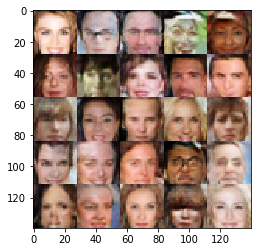

Epoch 2/2 Step 17210... Discriminator Loss: 1.3079... Generator Loss: 0.8075 ... Time spent=0.0646
Epoch 2/2 Step 17220... Discriminator Loss: 1.3765... Generator Loss: 0.7197 ... Time spent=0.0640
Epoch 2/2 Step 17230... Discriminator Loss: 1.5394... Generator Loss: 0.6315 ... Time spent=0.0635
Epoch 2/2 Step 17240... Discriminator Loss: 1.3508... Generator Loss: 0.8114 ... Time spent=0.0636
Epoch 2/2 Step 17250... Discriminator Loss: 1.2936... Generator Loss: 0.7435 ... Time spent=0.0638
Epoch 2/2 Step 17260... Discriminator Loss: 1.3894... Generator Loss: 0.6881 ... Time spent=0.0629
Epoch 2/2 Step 17270... Discriminator Loss: 1.3808... Generator Loss: 0.7950 ... Time spent=0.0636
Epoch 2/2 Step 17280... Discriminator Loss: 1.3930... Generator Loss: 0.7858 ... Time spent=0.0633
Epoch 2/2 Step 17290... Discriminator Loss: 1.3342... Generator Loss: 0.7607 ... Time spent=0.0645
Epoch 2/2 Step 17300... Discriminator Loss: 1.3700... Generator Loss: 0.7005 ... Time spent=0.0632
Epoch 2/2 

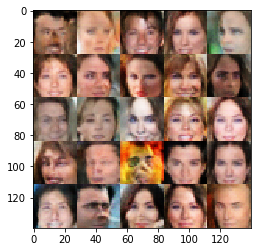

Epoch 2/2 Step 17410... Discriminator Loss: 1.3777... Generator Loss: 0.7080 ... Time spent=0.0638
Epoch 2/2 Step 17420... Discriminator Loss: 1.3484... Generator Loss: 0.7895 ... Time spent=0.0636
Epoch 2/2 Step 17430... Discriminator Loss: 1.5867... Generator Loss: 0.5508 ... Time spent=0.0635
Epoch 2/2 Step 17440... Discriminator Loss: 1.2815... Generator Loss: 0.6817 ... Time spent=0.0638
Epoch 2/2 Step 17450... Discriminator Loss: 1.2420... Generator Loss: 0.7532 ... Time spent=0.0634
Epoch 2/2 Step 17460... Discriminator Loss: 1.4352... Generator Loss: 0.6942 ... Time spent=0.0638
Epoch 2/2 Step 17470... Discriminator Loss: 1.4556... Generator Loss: 0.7577 ... Time spent=0.0644
Epoch 2/2 Step 17480... Discriminator Loss: 1.3027... Generator Loss: 0.7543 ... Time spent=0.0664
Epoch 2/2 Step 17490... Discriminator Loss: 1.2122... Generator Loss: 0.8743 ... Time spent=0.0636
Epoch 2/2 Step 17500... Discriminator Loss: 1.4433... Generator Loss: 0.6283 ... Time spent=0.0639
Epoch 2/2 

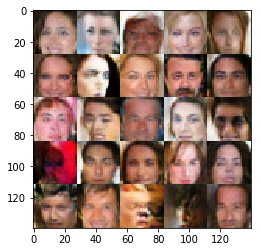

Epoch 2/2 Step 17610... Discriminator Loss: 1.3462... Generator Loss: 0.7075 ... Time spent=0.0640
Epoch 2/2 Step 17620... Discriminator Loss: 1.3049... Generator Loss: 0.7518 ... Time spent=0.0634
Epoch 2/2 Step 17630... Discriminator Loss: 1.5473... Generator Loss: 0.6163 ... Time spent=0.0628
Epoch 2/2 Step 17640... Discriminator Loss: 1.3208... Generator Loss: 0.7689 ... Time spent=0.0634
Epoch 2/2 Step 17650... Discriminator Loss: 1.3859... Generator Loss: 0.7496 ... Time spent=0.0647
Epoch 2/2 Step 17660... Discriminator Loss: 1.3102... Generator Loss: 0.7346 ... Time spent=0.0638
Epoch 2/2 Step 17670... Discriminator Loss: 1.2317... Generator Loss: 0.7356 ... Time spent=0.0643
Epoch 2/2 Step 17680... Discriminator Loss: 1.2763... Generator Loss: 0.7217 ... Time spent=0.0643
Epoch 2/2 Step 17690... Discriminator Loss: 1.3243... Generator Loss: 0.7479 ... Time spent=0.0635
Epoch 2/2 Step 17700... Discriminator Loss: 1.4479... Generator Loss: 0.6395 ... Time spent=0.0642
Epoch 2/2 

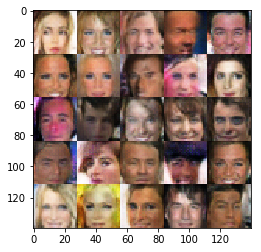

Epoch 2/2 Step 17810... Discriminator Loss: 1.5154... Generator Loss: 0.6355 ... Time spent=0.0627
Epoch 2/2 Step 17820... Discriminator Loss: 1.3470... Generator Loss: 0.8243 ... Time spent=0.0631
Epoch 2/2 Step 17830... Discriminator Loss: 1.3022... Generator Loss: 0.7608 ... Time spent=0.0641
Epoch 2/2 Step 17840... Discriminator Loss: 1.3223... Generator Loss: 0.7918 ... Time spent=0.0640
Epoch 2/2 Step 17850... Discriminator Loss: 1.4419... Generator Loss: 0.8154 ... Time spent=0.0639
Epoch 2/2 Step 17860... Discriminator Loss: 1.3728... Generator Loss: 0.6736 ... Time spent=0.0636
Epoch 2/2 Step 17870... Discriminator Loss: 1.4488... Generator Loss: 0.6163 ... Time spent=0.0633
Epoch 2/2 Step 17880... Discriminator Loss: 1.3995... Generator Loss: 0.6492 ... Time spent=0.0654
Epoch 2/2 Step 17890... Discriminator Loss: 1.3185... Generator Loss: 0.8097 ... Time spent=0.0633
Epoch 2/2 Step 17900... Discriminator Loss: 1.3508... Generator Loss: 0.7272 ... Time spent=0.0639
Epoch 2/2 

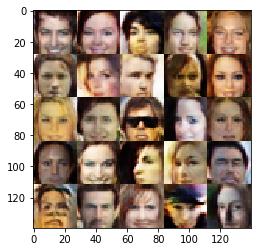

Epoch 2/2 Step 18010... Discriminator Loss: 1.3516... Generator Loss: 0.6615 ... Time spent=0.0635
Epoch 2/2 Step 18020... Discriminator Loss: 1.4200... Generator Loss: 0.7140 ... Time spent=0.0639
Epoch 2/2 Step 18030... Discriminator Loss: 1.4389... Generator Loss: 0.5919 ... Time spent=0.0644
Epoch 2/2 Step 18040... Discriminator Loss: 1.3141... Generator Loss: 0.7172 ... Time spent=0.0635
Epoch 2/2 Step 18050... Discriminator Loss: 1.2694... Generator Loss: 0.7281 ... Time spent=0.0643
Epoch 2/2 Step 18060... Discriminator Loss: 1.4041... Generator Loss: 0.7106 ... Time spent=0.0646
Epoch 2/2 Step 18070... Discriminator Loss: 1.2207... Generator Loss: 0.8381 ... Time spent=0.0636
Epoch 2/2 Step 18080... Discriminator Loss: 1.2704... Generator Loss: 0.8099 ... Time spent=0.0638
Epoch 2/2 Step 18090... Discriminator Loss: 1.3064... Generator Loss: 0.7763 ... Time spent=0.0637
Epoch 2/2 Step 18100... Discriminator Loss: 1.4277... Generator Loss: 0.6423 ... Time spent=0.0636
Epoch 2/2 

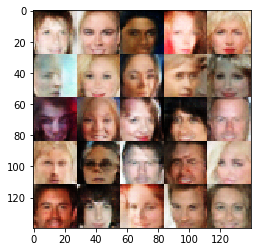

Epoch 2/2 Step 18210... Discriminator Loss: 1.4739... Generator Loss: 0.5689 ... Time spent=0.0649
Epoch 2/2 Step 18220... Discriminator Loss: 1.2061... Generator Loss: 0.7391 ... Time spent=0.0643
Epoch 2/2 Step 18230... Discriminator Loss: 1.3331... Generator Loss: 0.6688 ... Time spent=0.0634
Epoch 2/2 Step 18240... Discriminator Loss: 1.0540... Generator Loss: 0.9726 ... Time spent=0.0630
Epoch 2/2 Step 18250... Discriminator Loss: 1.3994... Generator Loss: 0.7306 ... Time spent=0.0651
Epoch 2/2 Step 18260... Discriminator Loss: 1.2817... Generator Loss: 0.7282 ... Time spent=0.0628
Epoch 2/2 Step 18270... Discriminator Loss: 1.2143... Generator Loss: 0.7962 ... Time spent=0.0636
Epoch 2/2 Step 18280... Discriminator Loss: 1.1137... Generator Loss: 0.9123 ... Time spent=0.0637
Epoch 2/2 Step 18290... Discriminator Loss: 1.3799... Generator Loss: 0.6829 ... Time spent=0.0635
Epoch 2/2 Step 18300... Discriminator Loss: 1.4609... Generator Loss: 0.6500 ... Time spent=0.0644
Epoch 2/2 

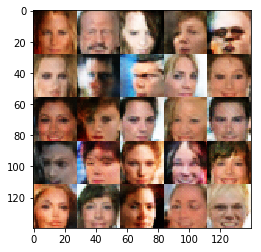

Epoch 2/2 Step 18410... Discriminator Loss: 1.1718... Generator Loss: 0.8227 ... Time spent=0.0636
Epoch 2/2 Step 18420... Discriminator Loss: 1.3398... Generator Loss: 0.7045 ... Time spent=0.0634
Epoch 2/2 Step 18430... Discriminator Loss: 1.2469... Generator Loss: 0.9118 ... Time spent=0.0646
Epoch 2/2 Step 18440... Discriminator Loss: 1.3652... Generator Loss: 0.7500 ... Time spent=0.0631
Epoch 2/2 Step 18450... Discriminator Loss: 1.4059... Generator Loss: 0.7303 ... Time spent=0.0640
Epoch 2/2 Step 18460... Discriminator Loss: 1.2838... Generator Loss: 0.7848 ... Time spent=0.0641
Epoch 2/2 Step 18470... Discriminator Loss: 1.3578... Generator Loss: 0.7293 ... Time spent=0.0644
Epoch 2/2 Step 18480... Discriminator Loss: 1.3125... Generator Loss: 0.7524 ... Time spent=0.0642
Epoch 2/2 Step 18490... Discriminator Loss: 1.3488... Generator Loss: 0.6878 ... Time spent=0.0645
Epoch 2/2 Step 18500... Discriminator Loss: 1.3902... Generator Loss: 0.6648 ... Time spent=0.0655
Epoch 2/2 

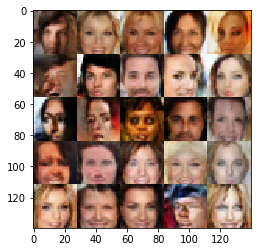

Epoch 2/2 Step 18610... Discriminator Loss: 1.3627... Generator Loss: 0.6320 ... Time spent=0.0631
Epoch 2/2 Step 18620... Discriminator Loss: 1.2750... Generator Loss: 0.7345 ... Time spent=0.0627
Epoch 2/2 Step 18630... Discriminator Loss: 1.3476... Generator Loss: 0.7286 ... Time spent=0.0643
Epoch 2/2 Step 18640... Discriminator Loss: 1.3326... Generator Loss: 0.7799 ... Time spent=0.0637
Epoch 2/2 Step 18650... Discriminator Loss: 1.1610... Generator Loss: 0.9075 ... Time spent=0.0645
Epoch 2/2 Step 18660... Discriminator Loss: 1.4533... Generator Loss: 0.7039 ... Time spent=0.0632
Epoch 2/2 Step 18670... Discriminator Loss: 1.3163... Generator Loss: 0.7071 ... Time spent=0.0643
Epoch 2/2 Step 18680... Discriminator Loss: 1.4343... Generator Loss: 0.6477 ... Time spent=0.0628
Epoch 2/2 Step 18690... Discriminator Loss: 1.2759... Generator Loss: 0.8046 ... Time spent=0.0646
Epoch 2/2 Step 18700... Discriminator Loss: 1.4552... Generator Loss: 0.7225 ... Time spent=0.0637
Epoch 2/2 

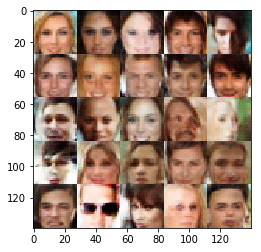

Epoch 2/2 Step 18810... Discriminator Loss: 1.4559... Generator Loss: 0.6783 ... Time spent=0.0636
Epoch 2/2 Step 18820... Discriminator Loss: 1.2333... Generator Loss: 0.8406 ... Time spent=0.0646
Epoch 2/2 Step 18830... Discriminator Loss: 1.3937... Generator Loss: 0.6507 ... Time spent=0.0656
Epoch 2/2 Step 18840... Discriminator Loss: 1.1937... Generator Loss: 0.8558 ... Time spent=0.0636
Epoch 2/2 Step 18850... Discriminator Loss: 1.2857... Generator Loss: 0.7433 ... Time spent=0.0642
Epoch 2/2 Step 18860... Discriminator Loss: 1.2073... Generator Loss: 0.8564 ... Time spent=0.0638
Epoch 2/2 Step 18870... Discriminator Loss: 1.1190... Generator Loss: 0.9326 ... Time spent=0.0630
Epoch 2/2 Step 18880... Discriminator Loss: 1.3948... Generator Loss: 0.6718 ... Time spent=0.0641
Epoch 2/2 Step 18890... Discriminator Loss: 1.4822... Generator Loss: 0.6059 ... Time spent=0.0636
Epoch 2/2 Step 18900... Discriminator Loss: 1.1214... Generator Loss: 0.9327 ... Time spent=0.0646
Epoch 2/2 

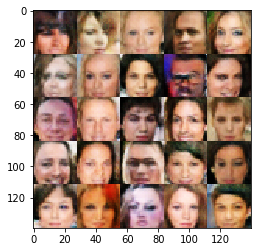

Epoch 2/2 Step 19010... Discriminator Loss: 1.3873... Generator Loss: 0.6316 ... Time spent=0.0638
Epoch 2/2 Step 19020... Discriminator Loss: 1.3213... Generator Loss: 0.7868 ... Time spent=0.0638
Epoch 2/2 Step 19030... Discriminator Loss: 1.5841... Generator Loss: 0.6904 ... Time spent=0.0629
Epoch 2/2 Step 19040... Discriminator Loss: 1.3512... Generator Loss: 0.6757 ... Time spent=0.0635
Epoch 2/2 Step 19050... Discriminator Loss: 1.4412... Generator Loss: 0.6360 ... Time spent=0.0646
Epoch 2/2 Step 19060... Discriminator Loss: 1.3810... Generator Loss: 0.8009 ... Time spent=0.0633
Epoch 2/2 Step 19070... Discriminator Loss: 1.2752... Generator Loss: 0.8381 ... Time spent=0.0633
Epoch 2/2 Step 19080... Discriminator Loss: 1.0960... Generator Loss: 0.9679 ... Time spent=0.0641
Epoch 2/2 Step 19090... Discriminator Loss: 1.3568... Generator Loss: 0.6974 ... Time spent=0.0645
Epoch 2/2 Step 19100... Discriminator Loss: 1.3090... Generator Loss: 0.7133 ... Time spent=0.0623
Epoch 2/2 

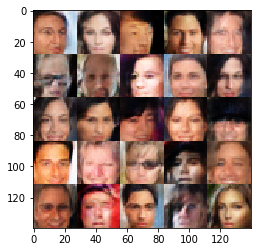

Epoch 2/2 Step 19210... Discriminator Loss: 1.3186... Generator Loss: 0.7480 ... Time spent=0.0641
Epoch 2/2 Step 19220... Discriminator Loss: 1.3998... Generator Loss: 0.6607 ... Time spent=0.0647
Epoch 2/2 Step 19230... Discriminator Loss: 1.4882... Generator Loss: 0.5753 ... Time spent=0.0633
Epoch 2/2 Step 19240... Discriminator Loss: 1.4246... Generator Loss: 0.5992 ... Time spent=0.0637
Epoch 2/2 Step 19250... Discriminator Loss: 1.1667... Generator Loss: 0.8410 ... Time spent=0.0636
Epoch 2/2 Step 19260... Discriminator Loss: 1.4324... Generator Loss: 0.6290 ... Time spent=0.0640
Epoch 2/2 Step 19270... Discriminator Loss: 1.1900... Generator Loss: 0.8628 ... Time spent=0.0628
Epoch 2/2 Step 19280... Discriminator Loss: 1.4069... Generator Loss: 0.6625 ... Time spent=0.0637
Epoch 2/2 Step 19290... Discriminator Loss: 1.3695... Generator Loss: 0.7306 ... Time spent=0.0642
Epoch 2/2 Step 19300... Discriminator Loss: 1.3795... Generator Loss: 0.6800 ... Time spent=0.0635
Epoch 2/2 

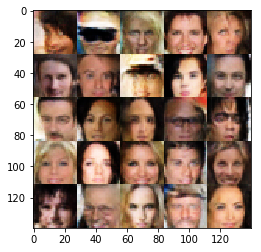

Epoch 2/2 Step 19410... Discriminator Loss: 1.2468... Generator Loss: 0.7016 ... Time spent=0.0639
Epoch 2/2 Step 19420... Discriminator Loss: 1.2581... Generator Loss: 0.7365 ... Time spent=0.0638
Epoch 2/2 Step 19430... Discriminator Loss: 1.3602... Generator Loss: 0.7453 ... Time spent=0.0644
Epoch 2/2 Step 19440... Discriminator Loss: 1.3840... Generator Loss: 0.6889 ... Time spent=0.0648
Epoch 2/2 Step 19450... Discriminator Loss: 1.2707... Generator Loss: 0.7649 ... Time spent=0.0634
Epoch 2/2 Step 19460... Discriminator Loss: 1.2767... Generator Loss: 0.7465 ... Time spent=0.0634
Epoch 2/2 Step 19470... Discriminator Loss: 1.3829... Generator Loss: 0.7780 ... Time spent=0.0636
Epoch 2/2 Step 19480... Discriminator Loss: 1.4184... Generator Loss: 0.7064 ... Time spent=0.0635
Epoch 2/2 Step 19490... Discriminator Loss: 1.2986... Generator Loss: 0.7035 ... Time spent=0.0633
Epoch 2/2 Step 19500... Discriminator Loss: 1.2830... Generator Loss: 0.7878 ... Time spent=0.0638
Epoch 2/2 

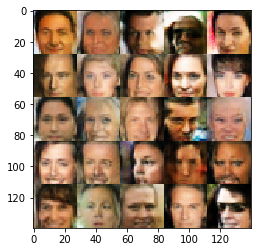

Epoch 2/2 Step 19610... Discriminator Loss: 1.2861... Generator Loss: 0.8123 ... Time spent=0.0632
Epoch 2/2 Step 19620... Discriminator Loss: 1.1231... Generator Loss: 0.8726 ... Time spent=0.0637
Epoch 2/2 Step 19630... Discriminator Loss: 1.1882... Generator Loss: 0.7859 ... Time spent=0.0636
Epoch 2/2 Step 19640... Discriminator Loss: 1.2839... Generator Loss: 0.7730 ... Time spent=0.0646
Epoch 2/2 Step 19650... Discriminator Loss: 1.3175... Generator Loss: 0.7783 ... Time spent=0.0634
Epoch 2/2 Step 19660... Discriminator Loss: 1.2566... Generator Loss: 0.7052 ... Time spent=0.0640
Epoch 2/2 Step 19670... Discriminator Loss: 1.2640... Generator Loss: 0.7839 ... Time spent=0.0630
Epoch 2/2 Step 19680... Discriminator Loss: 1.4112... Generator Loss: 0.6755 ... Time spent=0.0636
Epoch 2/2 Step 19690... Discriminator Loss: 1.3892... Generator Loss: 0.6904 ... Time spent=0.0630
Epoch 2/2 Step 19700... Discriminator Loss: 1.3434... Generator Loss: 0.7359 ... Time spent=0.0648
Epoch 2/2 

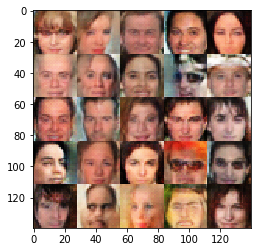

Epoch 2/2 Step 19810... Discriminator Loss: 1.2596... Generator Loss: 0.8737 ... Time spent=0.0634
Epoch 2/2 Step 19820... Discriminator Loss: 1.3535... Generator Loss: 0.6919 ... Time spent=0.0640
Epoch 2/2 Step 19830... Discriminator Loss: 1.1726... Generator Loss: 0.8931 ... Time spent=0.0640
Epoch 2/2 Step 19840... Discriminator Loss: 1.3755... Generator Loss: 0.7348 ... Time spent=0.0641
Epoch 2/2 Step 19850... Discriminator Loss: 1.3182... Generator Loss: 0.7992 ... Time spent=0.0633
Epoch 2/2 Step 19860... Discriminator Loss: 1.4477... Generator Loss: 0.6686 ... Time spent=0.0625
Epoch 2/2 Step 19870... Discriminator Loss: 1.5009... Generator Loss: 0.4785 ... Time spent=0.0639
Epoch 2/2 Step 19880... Discriminator Loss: 1.2258... Generator Loss: 0.8443 ... Time spent=0.0647
Epoch 2/2 Step 19890... Discriminator Loss: 1.3264... Generator Loss: 0.7865 ... Time spent=0.0634
Epoch 2/2 Step 19900... Discriminator Loss: 1.1433... Generator Loss: 0.8055 ... Time spent=0.0634
Epoch 2/2 

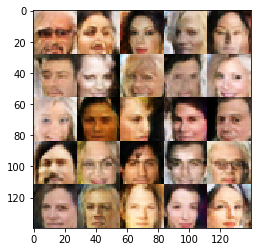

Epoch 2/2 Step 20010... Discriminator Loss: 1.3300... Generator Loss: 0.6781 ... Time spent=0.0660
Epoch 2/2 Step 20020... Discriminator Loss: 1.3732... Generator Loss: 0.6568 ... Time spent=0.0643
Epoch 2/2 Step 20030... Discriminator Loss: 1.4295... Generator Loss: 0.6077 ... Time spent=0.0638
Epoch 2/2 Step 20040... Discriminator Loss: 1.3069... Generator Loss: 0.7723 ... Time spent=0.0643
Epoch 2/2 Step 20050... Discriminator Loss: 1.3341... Generator Loss: 0.7400 ... Time spent=0.0636
Epoch 2/2 Step 20060... Discriminator Loss: 1.3533... Generator Loss: 0.7089 ... Time spent=0.0639
Epoch 2/2 Step 20070... Discriminator Loss: 1.2993... Generator Loss: 0.7459 ... Time spent=0.0643
Epoch 2/2 Step 20080... Discriminator Loss: 1.3758... Generator Loss: 0.6421 ... Time spent=0.0639
Epoch 2/2 Step 20090... Discriminator Loss: 1.2949... Generator Loss: 0.6732 ... Time spent=0.0640
Epoch 2/2 Step 20100... Discriminator Loss: 1.2855... Generator Loss: 0.7474 ... Time spent=0.0626
Epoch 2/2 

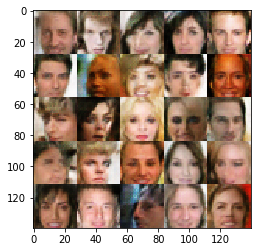

Epoch 2/2 Step 20210... Discriminator Loss: 1.1969... Generator Loss: 0.8679 ... Time spent=0.0638
Epoch 2/2 Step 20220... Discriminator Loss: 1.4363... Generator Loss: 0.6637 ... Time spent=0.0636
Epoch 2/2 Step 20230... Discriminator Loss: 1.4073... Generator Loss: 0.7059 ... Time spent=0.0654
Epoch 2/2 Step 20240... Discriminator Loss: 1.2177... Generator Loss: 0.8348 ... Time spent=0.0626
Epoch 2/2 Step 20250... Discriminator Loss: 1.2393... Generator Loss: 0.7222 ... Time spent=0.0640
Epoch 2/2 Step 20260... Discriminator Loss: 1.3508... Generator Loss: 0.7445 ... Time spent=0.0648
Epoch 2/2 Step 20270... Discriminator Loss: 1.2138... Generator Loss: 0.9944 ... Time spent=0.0635
Epoch 2/2 Step 20280... Discriminator Loss: 1.1270... Generator Loss: 0.9640 ... Time spent=0.0629
Epoch 2/2 Step 20290... Discriminator Loss: 1.3365... Generator Loss: 0.8119 ... Time spent=0.0630
Epoch 2/2 Step 20300... Discriminator Loss: 1.3524... Generator Loss: 0.6887 ... Time spent=0.0638
Epoch 2/2 

In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""


epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.